# Classical Scalar Regression

In this workbook, I will try predicting NFL Wide Receiver production using classical (non neural network) scalar prediction. 

> Note: By 'scalar' I mean that the output of the model is a single number: the Wide Receivers fantasy points. In another notebook, I'll be exploring outputting a vector: number of TD's, receiving yards, fumbles, etc. 

In [ ]:
import nfl_data_py as nfl
import pandas as pd

common_club_code_map =     {
        "LVR": "LV",
        "KCC": "KC",
        "NOS": "NO",
        "TBB": "TB",
        "SFO": "SF",
        "NEP": "NE",
        "LAR": "LA",
        "GBP": "GB",
        "JAC": "JAX",
        "OAK":"LV",
        "STL":"LAR",
        "SD":"LAC",
        "SDC":"LAC",
        "RAM":"LAR",
        "LA":"LAR"
    }
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

### From Class

In [2]:
import importlib
import prepare_data
_ = importlib.reload(prepare_data)


        I dropped 14 columns from the dataset.
        I also ...
        


C:\Users\cbrad\Documents\Code\DS Projects\Fantasy Football Dash\prepare_data.py:302: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  temp = pd.concat([temp, self._raw_wr_stats[(self._raw_wr_stats['season'] == row['season']) & \


The length of the dataset pre-windowing is: 16559
The length of the dataset post-windowing is: 10406


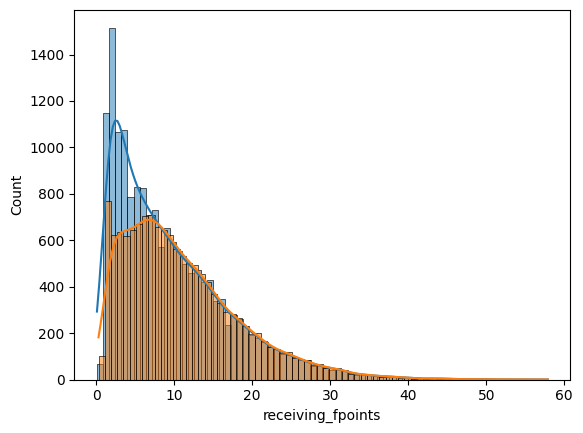

In [3]:
data_pipeline = prepare_data.PrepData()
data_pipeline.read_data()
data_pipeline.clean_data()
# this seems to be the best preparation for the data. 
# A smaller rolling window generally results in overfitting. 
data_pipeline.get_top_n(n = 64, roll_window = 4)
data_pipeline.window_data()
data_pipeline.add_external_stats()
data_pipeline.split_test_train(rand_split = True, test_size = 0.33)
data_pipeline.scale_data()

### ML

In [127]:
from sklearn.model_selection import cross_val_score, RepeatedKFold, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, HuberRegressor
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA

from skopt.space import Real, Integer, Categorical

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor, DMatrix, cv


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme()

def get_test_results(test_target, preds, id_map, init_data):
    results = pd.DataFrame(test_target)
    results['yhat'] = preds
    results = results.merge(id_map, how = 'left', left_index = True, right_index = True)
    results = results.merge(init_data, how = 'left', on=['player_id', 'game_id'])
    return results

# first let's establish a baseline model
def baseline_model(y, id_map, init_data):
    # grab results datafrmae
    results = pd.DataFrame(y)
    results = results.merge(id_map, how = 'left', left_index = True, right_index = True)
    results = results.merge(init_data.drop('receiving_fpoints',axis=1), how = 'left', on=['player_id', 'game_id'])
    
    prev_data = init_data[['player_id', 'week', 'season', 'receiving_fpoints']].copy().rename({'receiving_fpoints':'yhat'},axis=1)
    prev_data['week'] = prev_data['week'] + 1

    results = results.merge(prev_data, how='left', on=['player_id', 'week', 'season'])
    # if there was no data for the previous week, just predict the average. 
    # NOTE: This is probably bad practice since I am feeding information about the test set to the model, 
    # but there's no learning happening hear so I'm not worried about fitting issues.
    results['yhat'] = results['yhat'].fillna(init_data['receiving_fpoints'].mean())
    return results[['season',
                    'week',
                    'game_id', 
                    'player_id', 
                    'player_name',
                   'receiving_fpoints',
                    'yhat',
                    'ESPN_projection',
                    'receiving_yards', 
                     'receptions', 
                     'receiving_touchdowns',
                    'fumble_lost']]

# let's quickly see how good we can get XGBoost to predict
def modelfit(model, X, y, X_test, y_test, cols, useTrainCV=True, cv_folds=5, early_stopping_rounds=100, plot = False):

    cvresult = None
    if useTrainCV:
        xgb_param = model.get_xgb_params()
        xgtrain = DMatrix(X, label=y)
        cvresult = cv(xgb_param, xgtrain, num_boost_round=model.get_params()['n_estimators'], nfold=cv_folds,
            metrics='mae', early_stopping_rounds=early_stopping_rounds)
        model.set_params(n_estimators=cvresult.shape[0])
        print(f"n_estimators: {cvresult.shape[0]}")
    
    #Fit the algorithm on the data
    evalset = [(X, y), (X_test, y_test)]
    _ = model.fit(X, y, eval_set = evalset, verbose=False)
        
    #Predict training set:
    predictions = model.predict(X)
    # dtrain_predprob = alg.predict_proba(y)[:,1]
        
    #Print model report:
    print("\nModel Report\n-------- TRAIN --------")
    print("MAE : %.4g" % mean_absolute_error(y, predictions))
    print("R2: %f" % r2_score(y, predictions))

    #Predict training set:
    predictions_test = model.predict(X_test)
    # dtrain_predprob = alg.predict_proba(y)[:,1]
    
    print("\nModel Report\n-------- TEST --------")
    print("MAE : %.4g" % mean_absolute_error(y_test, predictions_test))
    print("R2: %f" % r2_score(y_test, predictions_test))   

    if plot:
        fix, ax = plt.subplots(2,1,figsize = (10,10))
        
        feat_imp = pd.DataFrame(list(zip(cols, model.feature_importances_)), columns = ['Feature', 'Score']) \
            .sort_values(by='Score', ascending=True) \
            .set_index('Feature')
        feat_imp.plot(title='Feature Importances', ax = ax[0], kind='barh')
        ax[0].set_xlabel('Feature Importance Score')

        results = model.evals_result()
        # plot learning curves
        ax[1].plot(results['validation_0']['mean_absolute_error'], label='train')
        ax[1].plot(results['validation_1']['mean_absolute_error'], label='test')
        # show the legend
        ax[1].set_ylabel('Mean Absolute Error')
        ax[1].set_xlabel('Epoch')
        ax[1].legend()

    return model, cvresult

def evaluate_models(data_pipeline, cv=3):
    # List of models
    models = {
        'Linear Regression': LinearRegression(),
        'Lasso Regression': Lasso(),
        'Ridge Regression': Ridge(),
        'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
        'Random Forest Regressor': RandomForestRegressor(n_jobs=-1, random_state=42),
        'XGB Regressor': XGBRegressor(n_jobs=-1, random_state=42),
        'SVM Regressor': SVR()
    }

    models['ElasticNet'] = ElasticNet()
    models['Gradient Boosting Regressor'] = GradientBoostingRegressor(random_state=42)
    models['LightGBM Regressor'] = LGBMRegressor(n_jobs=-1, random_state=42)
    models['CatBoost Regressor'] = CatBoostRegressor(verbose=0, random_state=42)
    models['KNeighbors Regressor'] = KNeighborsRegressor(n_jobs=-1)
    models['Bayesian Ridge Regression'] = BayesianRidge()
    models['Huber Regressor'] = HuberRegressor(max_iter=5000)
    models['AdaBoost Regressor'] = AdaBoostRegressor(random_state=42)
    models['MLP Regressor'] = MLPRegressor(random_state=42, max_iter=5000)
    
    results = []
    
    # Loop through the models
    for model_name, model in models.items():
        print(f"Cross Validating {model_name} using {cv} folds...")
        # Cross-validation
        cv_scores = cross_val_score(model, data_pipeline.X_train_scaled, data_pipeline.y_train_final, 
                                    scoring='neg_mean_squared_error', cv=cv)
        mean_cv_score = -np.mean(cv_scores)  # MAE
        std_cv_score = np.std(cv_scores)
        
        # Fit the model on the full training set
        model.fit(data_pipeline.X_train_scaled, data_pipeline.y_train_final)
        
        # Get predictions on the test set
        y_pred = model.predict(data_pipeline.X_test_scaled)
        
        # Calculate metrics on the test set
        test_mse = mean_squared_error(data_pipeline.y_test_final, y_pred)
        test_mae = mean_absolute_error(data_pipeline.y_test_final, y_pred)
        test_rmse = np.sqrt(test_mse)  # Calculate RMSE
        test_r2 = r2_score(data_pipeline.y_test_final, y_pred)
        
        # Store results in a list
        results.append({
            'Model': model_name,
            'Mean CV MSE': mean_cv_score,
            'Std Dev CV MSE': std_cv_score,
            'Test MSE': test_mse,
            'Test MAE': test_mae,
            'Test RMSE': test_rmse,
            'Test R2': test_r2,
            'Fit Gap': mean_cv_score - test_mse,
            'Fit Parameters': model.get_params()
        })
    
    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results).sort_values(by=['Mean CV MSE'])
    
    return results_df

def modelfit_general(model, data_pipeline, scoring_function=mean_absolute_error, plot=True, retrain_for_plots = True):
    # X = data_pipeline.X_train_scaled, 
    #                 y = data_pipeline.y_train_final, 
    #                 X_test = data_pipeline.X_test_scaled, 
    #                 y_test = data_pipeline.y_test_final, 
    # Fit the model

    cols = data_pipeline.X_train.columns.tolist()
    model.fit(data_pipeline.X_train_scaled, data_pipeline.y_train_final)
    
    # Make predictions
    predictions = model.predict(data_pipeline.X_train_scaled)
    predictions_test = model.predict(data_pipeline.X_test_scaled)

    # Print the model report using the custom scoring function
    print("\nModel Report\n-------- TRAIN --------")
    print(f"{scoring_function.__name__.upper()} : %.4g" % scoring_function(data_pipeline.y_train_final, predictions))
    print("R2: %f" % r2_score(data_pipeline.y_train_final, predictions))
    
    print("\nModel Report\n-------- TEST --------")
    print(f"{scoring_function.__name__.upper()} : %.4g" % scoring_function(data_pipeline.y_test_final, predictions_test))
    print("R2: %f" % r2_score(data_pipeline.y_test_final, predictions_test))


    # ESPN COMPS
    # get predictions
    ESPN_non_null = data_pipeline._wr_stats[~data_pipeline._wr_stats['ESPN_projection'].isna()].copy()
    print("\nModel Report\n-------- ESPN --------")
    print(f"{scoring_function.__name__.upper()} : %.4g" % scoring_function(ESPN_non_null['ESPN_projection'], ESPN_non_null['receiving_fpoints']))
    print("R2: %f" % r2_score(ESPN_non_null['receiving_fpoints'], ESPN_non_null['ESPN_projection']))

    # test results df
    test_results = get_test_results(test_target = data_pipeline.y_test, 
                                         preds = y_pred,
                                         id_map = data_pipeline._windowed_data[['player_id', 'game_id']], 
                                         init_data = data_pipeline._wr_stats[['player_id', 
                                                                              'player_name',
                                                         'game_id', 
                                                         'receiving_yards', 
                                                         'receptions', 
                                                         'receiving_touchdowns', 
                                                         'week', 
                                                         'fumble_lost',
                                                         'ESPN_projection']])
    test_results.sort_values(by=['yhat', 'player_id'], ascending = [False, False], inplace = True)
    test_results['mae'] = test_results.apply(lambda x: abs(x['receiving_fpoints'] - x['yhat']), axis=1)
    test_results['espn_mae'] = test_results.apply(lambda x: abs(x['receiving_fpoints'] - x['ESPN_projection']), axis=1)

    temp = test_results[~test_results['ESPN_projection'].isna()]
    print(f"\n\nThere are {temp.shape[0]} non-null ESPN entries in test")
    print(f"ESPN is better {temp[temp['mae'] > temp['espn_mae']].shape[0]} times. Or {100*temp[temp['mae'] > temp['espn_mae']].shape[0]/temp.shape[0]:,.2f}% of the time.")
    print(f"My model is better {temp[temp['mae'] < temp['espn_mae']].shape[0]} times. Or {100*temp[temp['mae'] < temp['espn_mae']].shape[0]/temp.shape[0]:,.2f}% of the time.")
    print(f"They are the same {temp[temp['mae'] == temp['espn_mae']].shape[0]} times.\n\n")
    
    if plot:
        fig, ax = plt.subplots(3, 1, figsize=(10, 20))
        
        # Plot feature importances for models that support it
        if hasattr(model, 'feature_importances_'):
            feat_imp = pd.DataFrame(list(zip(cols, model.feature_importances_)), columns=['Feature', 'Score']) \
                .sort_values(by='Score', ascending=True) \
                .set_index('Feature')
            feat_imp.plot(kind='barh', ax=ax[0], title='Feature Importances')
            ax[0].set_xlabel('Feature Importance Score')
        
        # Plot learning curves for models that support evaluation sets (like XGB, RandomForest)
        if hasattr(model, 'evals_result_'):
            results = model.evals_result()
            if 'validation_0' in results and 'mae' in results['validation_0']:
                ax[1].plot(results['validation_0']['mae'], label='train')
                ax[1].plot(results['validation_1']['mae'], label='test')
                ax[1].set_ylabel('Mean Absolute Error')
                ax[1].set_xlabel('Epoch')
                ax[1].legend()
        elif retrain_for_plots:
            # If the model doesn't provide learning curves, show loss for train and test manually
            print("############ manual training plots ###########")
            errors_train = []
            errors_test = []
            train_sizes = np.linspace(0.1, 1.0, 10)
            for size in train_sizes:
                X_train_sample = data_pipeline.X_train_scaled[:int(size * len(data_pipeline.X_train_scaled))]
                y_train_sample = data_pipeline.y_train_final[:int(size * len(data_pipeline.y_train_final))]
                model.fit(X_train_sample, y_train_sample)
                errors_train.append(scoring_function(y_train_sample, model.predict(X_train_sample)))
                errors_test.append(scoring_function(data_pipeline.y_test_final, model.predict(data_pipeline.X_test_scaled)))
            ax[1].plot(train_sizes, errors_train, label='Train Error')
            ax[1].plot(train_sizes, errors_test, label='Test Error')
            ax[1].set_ylabel(f'{scoring_function.__name__.upper()}')
            ax[1].set_xlabel('Training Set Size')
            ax[1].legend()

        # plot hists
        # Plot the histograms using seaborn on the same axis
        sns.histplot(temp['ESPN_projection'], kde=True, label='ESPN', ax=ax[2])
        sns.histplot(temp['yhat'], kde=True, label='Model', ax=ax[2])
        sns.histplot(temp['receiving_fpoints'], kde=True, label='Real Distro', ax=ax[2])
        # Set axis labels and title
        ax[2].set_xlabel('Projection Values')
        ax[2].set_ylabel('Frequency')
        ax[2].set_title('Comparison of ESPN Projections vs Model Predictions')
        
        # Display the legend
        ax[2].legend()

        
        plt.tight_layout()
        plt.show()

    return model, test_results

### OOB Linear Regression

In [5]:
# let's train a simple regression model to see how we do
reg = LinearRegression()
cross_val_score(reg, data_pipeline.X_train_scaled, data_pipeline.y_train_final, scoring='neg_mean_absolute_error', cv=3)

array([-5.95073015, -5.77398329, -5.67215956])

In [6]:
reg.fit(data_pipeline.X_train_scaled, data_pipeline.y_train_final)
y_pred_reg = reg.predict(data_pipeline.X_test_scaled)
print(f"MAE: {mean_absolute_error(np.asarray(data_pipeline.y_test_final), y_pred_reg)}")

MAE: 5.621687029886234


In [7]:
reg2_test_results = get_test_results(test_target = data_pipeline.y_test, 
                                     preds = y_pred_reg,
                                     id_map = data_pipeline._windowed_data[['player_id', 'game_id']], 
                                     init_data = data_pipeline._wr_stats[['player_id', 
                                                                          'player_name',
                                                     'game_id', 
                                                     'receiving_yards', 
                                                     'receptions', 
                                                     'receiving_touchdowns', 
                                                     'week', 
                                                     'fumble_lost',
                                                     'ESPN_projection']])
reg2_test_results.head()

receiving_fpoints       yhat   player_id          game_id  \
0                6.7  14.243014  00-0031382  2018_15_CLE_DEN   
1                8.5   8.825528  00-0022921   2019_17_ARI_LA   
2                7.2   5.784957  00-0035298  2023_10_ATL_ARI   
3                1.5  10.232314  00-0036331   2022_09_BAL_NO   
4                7.6   6.969392  00-0033536  2018_11_DEN_LAC   

        player_name  receiving_yards  receptions  receiving_touchdowns week  \
0     Jarvis Landry             37.0         3.0                   0.0   15   
1  Larry Fitzgerald             45.0         4.0                   0.0   17   
2      Scott Miller              2.0         1.0                   1.0   10   
3    Devin Duvernay              5.0         1.0                   0.0    9   
4     Mike Williams             56.0         2.0                   0.0   11   

   fumble_lost  ESPN_projection  
0          0.0        12.170674  
1          0.0        11.384631  
2          0.0        10.925793  
3          0.0        10.329056  
4          0.0        11.523730

### OOB Random Forest

In [8]:
# we could look at random forest as well
rf = RandomForestRegressor(max_depth=4, n_jobs = -1, random_state = 42)
cross_val_score(reg, data_pipeline.X_train_scaled, data_pipeline.y_train_final, scoring='neg_mean_absolute_error', cv=3)

array([-5.95073015, -5.77398329, -5.67215956])

In [9]:
rf.fit(data_pipeline.X_train_scaled, data_pipeline.y_train_final)

# get predictions
y_pred = rf.predict(data_pipeline.X_test_scaled)
print(f"MAE: {mean_absolute_error(data_pipeline.y_test_final, y_pred)}")

MAE: 5.546404603569511


In [10]:
rf_test_results = get_test_results(test_target = data_pipeline.y_test, 
                                     preds = y_pred,
                                     id_map = data_pipeline._windowed_data[['player_id', 'game_id']], 
                                     init_data = data_pipeline._wr_stats[['player_id', 
                                                                          'player_name',
                                                     'game_id', 
                                                     'receiving_yards', 
                                                     'receptions', 
                                                     'receiving_touchdowns', 
                                                     'week', 
                                                     'fumble_lost',
                                                     'ESPN_projection']])
rf_test_results.sort_values(by=['yhat', 'player_id'], ascending = [False, False]).head()

receiving_fpoints       yhat   player_id          game_id  \
495                31.3  19.006045  00-0036322  2022_16_NYG_MIN   
995                10.1  18.951301  00-0033040  2023_14_TEN_MIA   
1999               11.0  18.778459  00-0030564  2015_07_HOU_MIA   
436                10.6  18.700194  00-0031408   2016_10_CHI_TB   
2033               19.0  18.564709  00-0036900   2022_15_CIN_TB   

           player_name  receiving_yards  receptions  receiving_touchdowns  \
495   Justin Jefferson            133.0        12.0                   1.0   
995        Tyreek Hill             61.0         4.0                   0.0   
1999   DeAndre Hopkins             50.0         6.0                   0.0   
436         Mike Evans             66.0         4.0                   0.0   
2033     Ja'Marr Chase             60.0         7.0                   1.0   

     week  fumble_lost  ESPN_projection  
495    16          0.0        20.876500  
995    14          0.0        23.592585  
1999    7          0.0        14.256740  
436    10          0.0        14.386563  
2033   15          0.0        18.829648

Text(0.5, 0, 'Mean decrease in impurity')

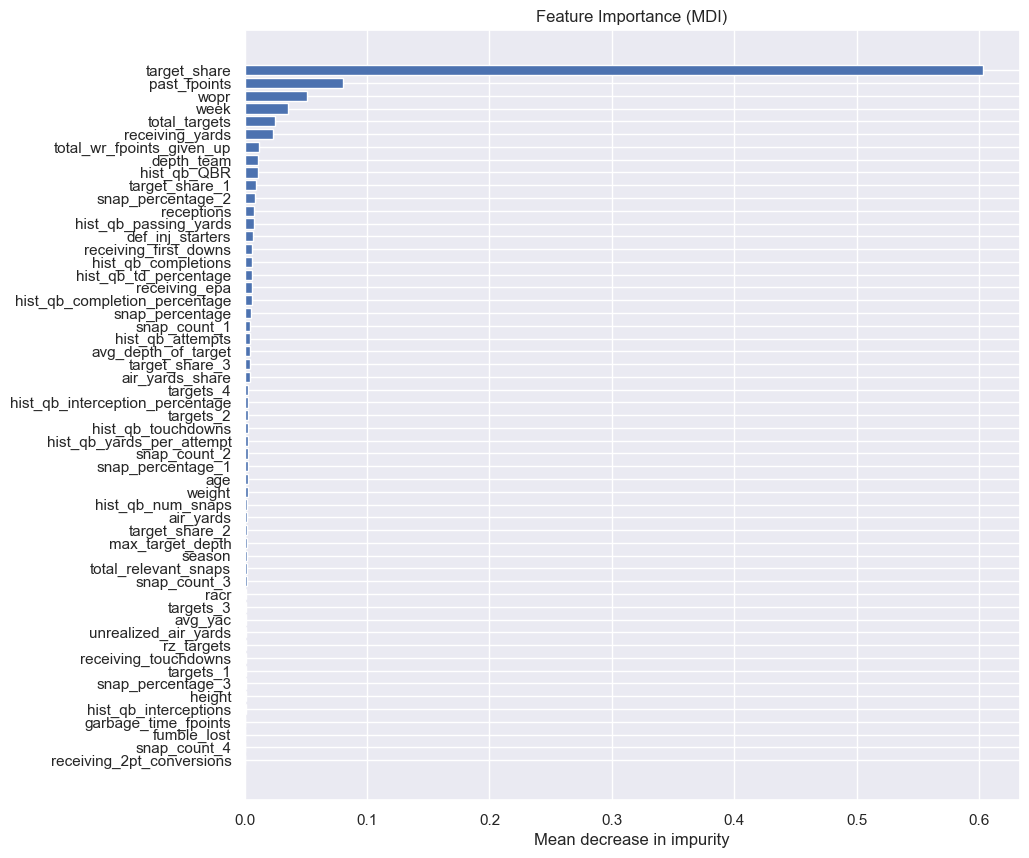

In [11]:
# obtain feature importance
feature_importance = rf.feature_importances_

# sort features according to importance
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
fig,ax = plt.subplots(figsize=(10,10))

ax.barh(pos, feature_importance[sorted_idx], align="center")

ax.set_yticks(pos, np.array(data_pipeline.feature_list)[sorted_idx])
ax.set_title("Feature Importance (MDI)")
ax.set_xlabel("Mean decrease in impurity")

In [12]:
# finally, let's look at XGBoost
xgb = XGBRegressor(max_depth=4, n_jobs = -1, random_state = 42)
cross_val_score(reg, data_pipeline.X_train_scaled, data_pipeline.y_train_final, scoring='neg_mean_absolute_error', cv=3)

array([-5.95073015, -5.77398329, -5.67215956])

In [13]:
xgb.fit(data_pipeline.X_train_scaled, data_pipeline.y_train_final)

# get predictions
y_pred = xgb.predict(data_pipeline.X_test_scaled)
print(f"MAE: {mean_absolute_error(data_pipeline.y_test_final, y_pred)}")

MAE: 5.735644920697099


In [14]:
xgb_test_results = get_test_results(data_pipeline.y_test, 
                                     preds = y_pred,
                                     id_map = data_pipeline._windowed_data[['player_id', 'game_id']], 
                                     init_data = data_pipeline._wr_stats[['player_id', 
                                                                          'player_name',
                                                     'game_id', 
                                                     'receiving_yards', 
                                                     'receptions', 
                                                     'receiving_touchdowns', 
                                                     'week', 
                                                     'fumble_lost',
                                                     'ESPN_projection']])
xgb_test_results.sort_values(by=['yhat', 'player_id'], ascending = [False, False]).head()

receiving_fpoints       yhat   player_id          game_id  \
798                28.2  30.263676  00-0032765   2019_08_ARI_NO   
2220                4.3  29.819410  00-0035640  2020_07_SEA_ARI   
995                10.1  29.711603  00-0033040  2023_14_TEN_MIA   
2862                8.6  29.238178  00-0030564   2015_12_NO_HOU   
2517                4.9  28.753040  00-0029293   2020_16_TB_DET   

          player_name  receiving_yards  receptions  receiving_touchdowns week  \
798    Michael Thomas            112.0        11.0                   1.0    8   
2220       DK Metcalf             23.0         2.0                   0.0    7   
995       Tyreek Hill             61.0         4.0                   0.0   14   
2862  DeAndre Hopkins             36.0         5.0                   0.0   12   
2517     Marvin Jones             19.0         3.0                   0.0   16   

      fumble_lost  ESPN_projection  
798           0.0        22.333719  
2220          0.0        16.777225  
995           0.0        23.592585  
2862          0.0        14.256740  
2517          0.0        15.052266

In [15]:


baseline_test_results = baseline_model(y = data_pipeline.y_test, 
                                    id_map = data_pipeline._windowed_data[['player_id', 'game_id']], 
                                     init_data = data_pipeline._wr_stats[['player_id', 
                                                                          'player_name',
                                                                          'receiving_fpoints',
                                                                             'game_id', 
                                                                             'receiving_yards', 
                                                                             'receptions', 
                                                                             'receiving_touchdowns', 
                                                                             'week', 
                                                                             'fumble_lost',
                                                                             'ESPN_projection',
                                                                         'season']])
baseline_test_results.head()

season week          game_id   player_id       player_name  \
0  2018.0   15  2018_15_CLE_DEN  00-0031382     Jarvis Landry   
1  2019.0   17   2019_17_ARI_LA  00-0022921  Larry Fitzgerald   
2  2023.0   10  2023_10_ATL_ARI  00-0035298      Scott Miller   
3  2022.0    9   2022_09_BAL_NO  00-0036331    Devin Duvernay   
4  2018.0   11  2018_11_DEN_LAC  00-0033536     Mike Williams   

   receiving_fpoints  yhat  ESPN_projection  receiving_yards  receptions  \
0                6.7  12.7        12.170674             37.0         3.0   
1                8.5  14.8        11.384631             45.0         4.0   
2                7.2   0.0        10.925793              2.0         1.0   
3                1.5   7.1        10.329056              5.0         1.0   
4                7.6   0.0        11.523730             56.0         2.0   

   receiving_touchdowns  fumble_lost  
0                   0.0          0.0  
1                   0.0          0.0  
2                   1.0          0.0  
3                   0.0          0.0  
4                   0.0          0.0

In [16]:
# get predictions
print(f"MAE: {mean_absolute_error(baseline_test_results['receiving_fpoints'], baseline_test_results['yhat'])}")

MAE: 7.166679707387347


### A decent XGB


n_estimators: 59

Model Report
-------- TRAIN --------
MAE : 5.562
R2: 0.204418

Model Report
-------- TEST --------
MAE : 5.576
R2: 0.178756


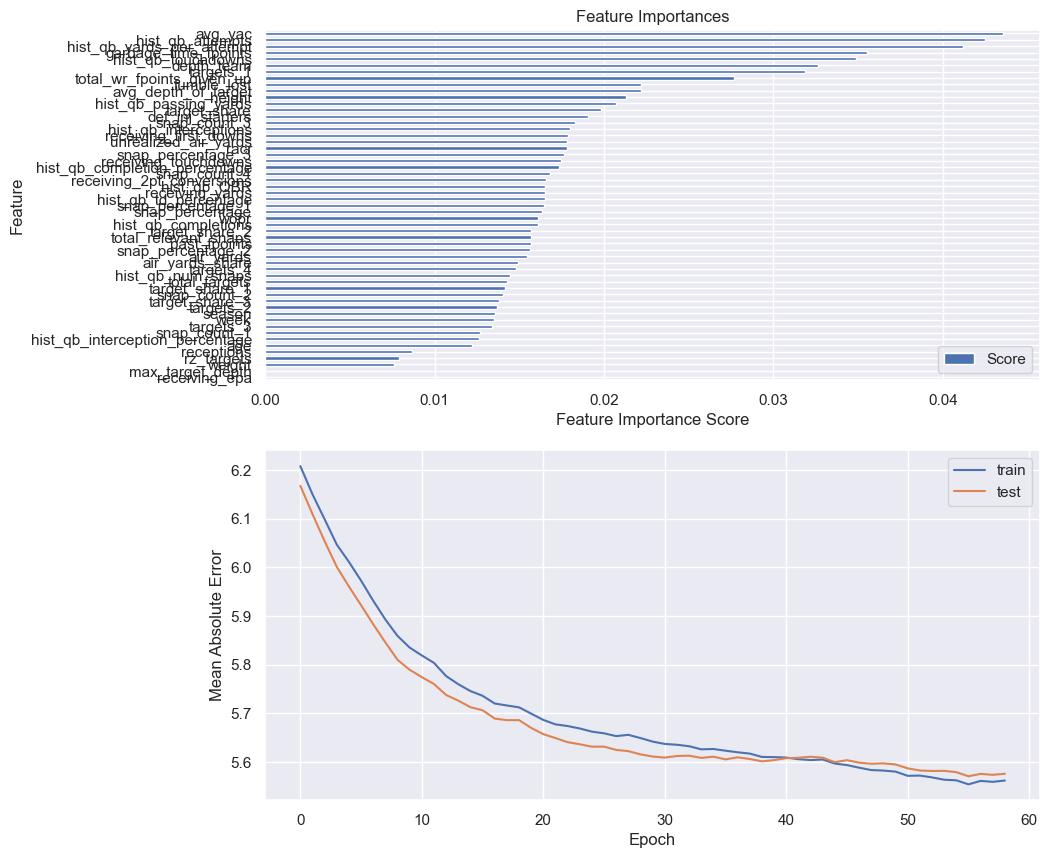

In [18]:
xgb = XGBRegressor(
    n_estimators = 1_000,
    max_depth = 3,
    max_leaves = 0,
    n_jobs = -1,
    eval_metric=mean_absolute_error,
    subsample = 0.1,
    gamma = 0,
    colsample_bytree = 0.5,
    learning_rate = 0.07,
    min_child_weight = 1,
    alpha = 0
)

xgb, cv_results = modelfit(model = xgb, 
                           X = data_pipeline.X_train_scaled, 
                           y = data_pipeline.y_train_final, 
                           X_test = data_pipeline.X_test_scaled, 
                           y_test = data_pipeline.y_test_final, 
                           cols = data_pipeline.X_train.columns.tolist(),
                           plot = True)

In [19]:

# get predictions
ESPN_non_null = data_pipeline._wr_stats[~data_pipeline._wr_stats['ESPN_projection'].isna()].copy()
y_pred = xgb.predict(data_pipeline.X_test_scaled)
print(f"MAE: {mean_absolute_error(data_pipeline.y_test_final, y_pred)}")
print(f"ESPN MAE: {mean_absolute_error(ESPN_non_null['ESPN_projection'], ESPN_non_null['receiving_fpoints'])}")
xgb_test_results = get_test_results(test_target = data_pipeline.y_test, 
                                     preds = y_pred,
                                     id_map = data_pipeline._windowed_data[['player_id', 'game_id']], 
                                     init_data = data_pipeline._wr_stats[['player_id', 
                                                                          'player_name',
                                                     'game_id', 
                                                     'receiving_yards', 
                                                     'receptions', 
                                                     'receiving_touchdowns', 
                                                     'week', 
                                                     'fumble_lost',
                                                     'ESPN_projection']])
xgb_test_results.sort_values(by=['yhat', 'player_id'], ascending = [False, False]).head()

MAE: 5.576165929775149
ESPN MAE: 6.404816621238777


receiving_fpoints       yhat   player_id          game_id  \
911                15.7  26.023052  00-0027793  2015_14_PIT_CIN   
1387               10.4  23.588478  00-0030279   2017_15_LAC_KC   
652                17.1  22.143938  00-0030279  2017_14_WAS_LAC   
276                21.5  21.679144  00-0033908   2021_17_LA_BAL   
995                10.1  21.350681  00-0033040  2023_14_TEN_MIA   

        player_name  receiving_yards  receptions  receiving_touchdowns week  \
911   Antonio Brown             87.0         7.0                   0.0   14   
1387   Keenan Allen             54.0         5.0                   0.0   15   
652    Keenan Allen            111.0         6.0                   0.0   14   
276     Cooper Kupp             95.0         6.0                   1.0   17   
995     Tyreek Hill             61.0         4.0                   0.0   14   

      fumble_lost  ESPN_projection  
911           0.0        12.733724  
1387          0.0        15.889512  
652           0.0        15.889512  
276           0.0        26.151671  
995           0.0        23.592585

In [20]:
xgb_test_results['mae'] = xgb_test_results.apply(lambda x: abs(x['receiving_fpoints'] - x['yhat']), axis=1)
xgb_test_results['espn_mae'] = xgb_test_results.apply(lambda x: abs(x['receiving_fpoints'] - x['ESPN_projection']), axis=1)
xgb_test_results.sort_values(by=['mae'], ascending = True).head(5)

receiving_fpoints       yhat   player_id          game_id  \
1097                6.5   6.499079  00-0030669   2016_10_KC_CAR   
2360                8.9   8.890679  00-0034775   2021_05_SF_ARI   
3410                9.7   9.685159  00-0028002   2015_17_MIN_GB   
1758               16.5  16.518692  00-0031408    2016_11_TB_KC   
2209                6.0   6.018765  00-0026035  2018_15_MIA_MIN   

         player_name  receiving_yards  receptions  receiving_touchdowns week  \
1097   Albert Wilson             25.0         4.0                   0.0   10   
2360  Christian Kirk             39.0         5.0                   0.0    5   
3410    Randall Cobb             37.0         6.0                   0.0   17   
1758      Mike Evans            105.0         6.0                   0.0   11   
2209  Danny Amendola             30.0         3.0                   0.0   15   

      fumble_lost  ESPN_projection       mae  espn_mae  
1097          0.0        10.874442  0.000921  4.374442  
2360          0.0        11.266596  0.009321  2.366595  
3410          0.0         7.297210  0.014841  2.402790  
1758          0.0        14.386563  0.018692  2.113438  
2209          0.0        10.470589  0.018765  4.470589

In [21]:
temp = xgb_test_results[~xgb_test_results['ESPN_projection'].isna()]
print(f"There are {temp.shape[0]} non-null ESPN entries in test")
print(f"ESPN is better {temp[temp['mae'] > temp['espn_mae']].shape[0]} times. Or {100*temp[temp['mae'] > temp['espn_mae']].shape[0]/temp.shape[0]:,.2f}% of the time.")
print(f"XGB is better {temp[temp['mae'] < temp['espn_mae']].shape[0]} times. Or {100*temp[temp['mae'] < temp['espn_mae']].shape[0]/temp.shape[0]:,.2f}% of the time.")
print(f"They are the same {temp[temp['mae'] == temp['espn_mae']].shape[0]} times.")

There are 3435 non-null ESPN entries in test
ESPN is better 1462 times. Or 42.56% of the time.
XGB is better 1973 times. Or 57.44% of the time.
They are the same 0 times.


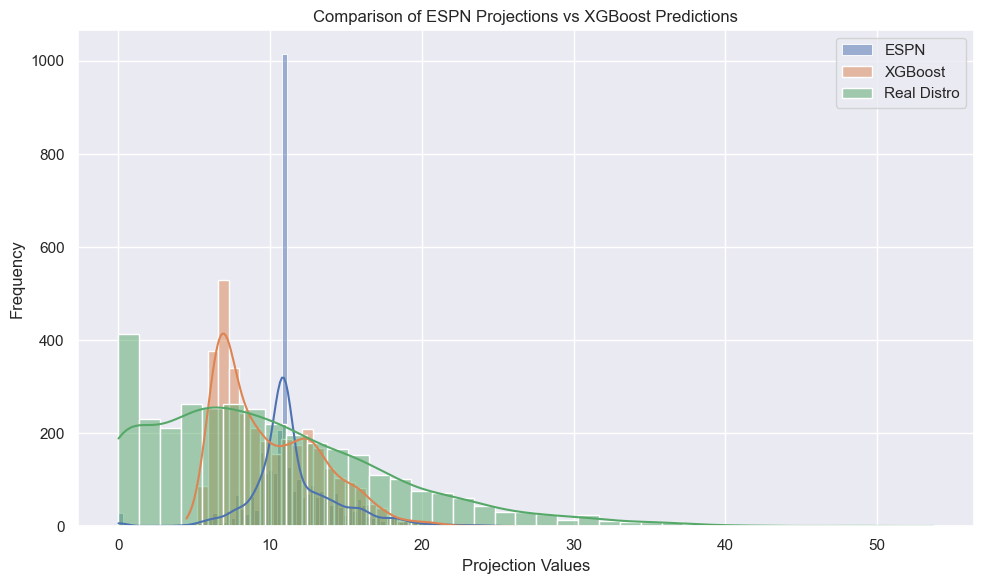

In [22]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the histograms using seaborn on the same axis
sns.histplot(temp['ESPN_projection'], kde=True, label='ESPN', ax=ax)
sns.histplot(temp['yhat'], kde=True, label='XGBoost', ax=ax)
sns.histplot(temp['receiving_fpoints'], kde=True, label='Real Distro', ax=ax)
# Set axis labels and title
ax.set_xlabel('Projection Values')
ax.set_ylabel('Frequency')
ax.set_title('Comparison of ESPN Projections vs XGBoost Predictions')

# Display the legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

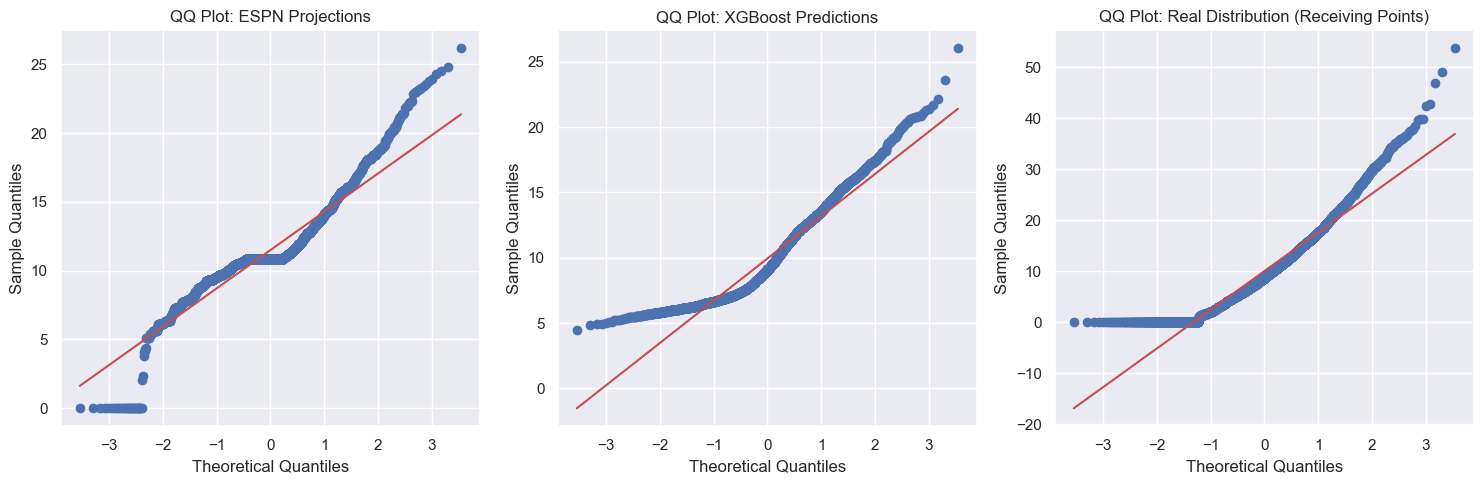

In [23]:
import scipy.stats as stats

# Create the figure and axes
fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns for 3 QQ plots

# QQ plot for ESPN Projections
stats.probplot(temp['ESPN_projection'], dist="norm", plot=ax[0])
ax[0].set_title('QQ Plot: ESPN Projections')
ax[0].set_xlabel('Theoretical Quantiles')
ax[0].set_ylabel('Sample Quantiles')

# QQ plot for XGBoost Predictions
stats.probplot(temp['yhat'], dist="norm", plot=ax[1])
ax[1].set_title('QQ Plot: XGBoost Predictions')
ax[1].set_xlabel('Theoretical Quantiles')
ax[1].set_ylabel('Sample Quantiles')

# QQ plot for Real Distribution (Receiving Points)
stats.probplot(temp['receiving_fpoints'], dist="norm", plot=ax[2])
ax[2].set_title('QQ Plot: Real Distribution (Receiving Points)')
ax[2].set_xlabel('Theoretical Quantiles')
ax[2].set_ylabel('Sample Quantiles')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [24]:
from scipy.stats import shapiro
print(temp.shape[0])
for col in ['ESPN_projection', 'yhat', 'receiving_fpoints']:
    stat, p = shapiro(temp[col])
    if col == 'ESPN_projection':
        stat_type = 'ESPN Projection'
    elif col == 'yhat':
        stat_type = 'XGB Projection'
    else:
        stat_type = 'True Total'
    
    print(f'{stat_type} --- Statistic={stat:.3f}, p={p:.5f}')

    # interpret
    alpha = 0.05
    if p > alpha:
        print('... Sample looks Normal')
    else:
        print('... Sample does not look Normal')

3435
ESPN Projection --- Statistic=0.897, p=0.00000
... Sample does not look Normal
XGB Projection --- Statistic=0.923, p=0.00000
... Sample does not look Normal
True Total --- Statistic=0.933, p=0.00000
... Sample does not look Normal


In [25]:
from scipy.stats import ttest_ind, ranksums

xgb_espn_stt = ttest_ind(temp['ESPN_projection'].values, temp['yhat'].values, equal_var = False, alternative = 'greater')
xgb_true_stt = ttest_ind(temp['yhat'].values, temp['receiving_fpoints'].values, equal_var = False, alternative = 'greater')
espn_true_stt = ttest_ind(temp['ESPN_projection'].values, temp['receiving_fpoints'].values, equal_var = False, alternative = 'greater')

xgb_espn_npt = ranksums(temp['ESPN_projection'].values, temp['yhat'].values, alternative = 'greater')
xgb_true_npt = ranksums(temp['yhat'].values, temp['receiving_fpoints'].values, alternative = 'greater')
espn_true_npt = ranksums(temp['ESPN_projection'].values, temp['receiving_fpoints'].values, alternative = 'greater')

stats = [
    {
        'Compared Stats': 'XGB Predictions vs. ESPN Predictions',
        'Test':'T-test',
        'Statistic':xgb_espn_stt.statistic,
        'p_value':round(xgb_espn_stt.pvalue, 3)
    },
    {
        'Compared Stats': 'XGB Predictions vs. ESPN Predictions',
        'Test':'Rank Sums',
        'Statistic':xgb_espn_npt.statistic,
        'p_value':round(xgb_espn_npt.pvalue, 3)
    },
    {
        'Compared Stats': 'True Totals vs. XGB Predictions',
        'Test':'T-test',
        'Statistic':xgb_true_stt.statistic,
        'p_value':round(xgb_true_stt.pvalue, 3)
    },
    {
        'Compared Stats': 'True Totals vs. XGB Predictions',
        'Test':'Rank Sums',
        'Statistic':xgb_true_npt.statistic,
        'p_value':round(xgb_true_npt.pvalue, 3)
    },
    {
        'Compared Stats': 'True Totals vs. ESPN Predictions',
        'Test':'T-test',
        'Statistic':espn_true_stt.statistic,
        'p_value':round(espn_true_stt.pvalue, 3)
    },
    {
        'Compared Stats': 'True Totals vs. ESPN Predictions',
        'Test':'Rank Sums',
        'Statistic':espn_true_npt.statistic,
        'p_value':round(espn_true_npt.pvalue, 3)
    },
]

projection_stats = pd.DataFrame(stats)
alpha = 0.05
projection_stats['Hypothesis Test'] = projection_stats['p_value'].apply(lambda x: False if x > alpha else True)
projection_stats

Compared Stats       Test  Statistic  p_value  \
0  XGB Predictions vs. ESPN Predictions     T-test  20.326574    0.000   
1  XGB Predictions vs. ESPN Predictions  Rank Sums  22.599423    0.000   
2       True Totals vs. XGB Predictions     T-test  -0.764511    0.778   
3       True Totals vs. XGB Predictions  Rank Sums   6.445132    0.000   
4      True Totals vs. ESPN Predictions     T-test  10.051632    0.000   
5      True Totals vs. ESPN Predictions  Rank Sums  17.185677    0.000   

   Hypothesis Test  
0             True  
1             True  
2            False  
3             True  
4             True  
5             True

### Thoughts

My model works much better than ESPN! Almost a full point on average. It looks like my model is a little closer to the true distribution than ESPN is (check out the non-parametric tests above). What can I do better? 

1. Feature selection
   1. Let's try some advanced methods such as PCA and LDA
2. New models
    1. We should try SVD, Lasso & Ridge, Neural Networks
3. Re-architect as a time-series
    1. Could we do better at the outliers this way?
    2. Try ARIMA & LSTM
4. Ensemble methods.
    1. One model type may be better at edges of distro than others?
5. Random Forests are still better. Let's get training plots and fione tuning going.
6. True parameter searches
    1. So far, we've kind of half assed the parameter search. Let's do better.
7. Let's also switch to MSE as it is it will prevent our model from trying to fit the centroid too much

### Proper model comparisons

let's run k-fold CV on all our models

In [121]:
model_performance = evaluate_models(data_pipeline = data_pipeline)

Cross Validating Linear Regression using 3 folds...
Cross Validating Lasso Regression using 3 folds...
Cross Validating Ridge Regression using 3 folds...
Cross Validating Decision Tree Regressor using 3 folds...
Cross Validating Random Forest Regressor using 3 folds...
Cross Validating XGB Regressor using 3 folds...
Cross Validating SVM Regressor using 3 folds...
Cross Validating ElasticNet using 3 folds...
Cross Validating Gradient Boosting Regressor using 3 folds...
Cross Validating LightGBM Regressor using 3 folds...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8457
[LightGBM] [Info] Number of data points in the train set: 4648, number of used features: 54
[LightGBM] [Info] Start training from score 10.116201
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002293 seconds.
You can set `force_col_wise=

In [122]:
model_performance

Model  Mean CV MSE  Std Dev CV MSE    Test MSE  \
8   Gradient Boosting Regressor    54.000079        1.959525   49.640003   
12    Bayesian Ridge Regression    54.674058        2.682113   51.136672   
4       Random Forest Regressor    54.685752        2.307697   50.762581   
2              Ridge Regression    54.866576        2.790923   51.091653   
0             Linear Regression    55.016817        2.702799   51.131599   
10           CatBoost Regressor    55.523144        2.084435   51.836651   
9            LightGBM Regressor    55.683392        2.062323   51.130761   
13              Huber Regressor    55.732546        2.891230   51.889700   
7                    ElasticNet    55.839134        2.614278   52.264038   
6                 SVM Regressor    56.043384        2.722765   52.541599   
1              Lasso Regression    56.428550        2.801809   53.002496   
5                 XGB Regressor    62.385696        2.464487   58.519003   
11         KNeighbors Regressor    64.450967        2.680241   59.297919   
14           AdaBoost Regressor    70.078690        6.911083   73.374875   
15                MLP Regressor    78.737537        4.097853   70.001014   
3       Decision Tree Regressor   113.800936        3.255534  104.126898   

    Test MAE  Test RMSE   Test R2   Fit Gap  \
8   5.519627   7.045566  0.196847  4.360076   
12  5.634735   7.150991  0.172632  3.537386   
4   5.604556   7.124786  0.178685  3.923170   
2   5.623913   7.147843  0.173360  3.774924   
0   5.621687   7.150636  0.172714  3.885218   
10  5.634496   7.199767  0.161307  3.686493   
9   5.600176   7.150578  0.172728  4.552632   
13  5.561959   7.203451  0.160448  3.842846   
7   5.714764   7.229387  0.154392  3.575097   
6   5.543792   7.248558  0.149901  3.501785   
1   5.750741   7.280281  0.142444  3.426054   
5   5.963284   7.649771  0.053189  3.866693   
11  6.003337   7.700514  0.040587  5.153048   
14  7.283193   8.565914 -0.187172 -3.296185   
15  6.580678   8.366661 -0.132584  8.736523   
3   7.766570  10.204259 -0.684726  9.674038   

                                       Fit Parameters  
8   {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...  
12  {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'alpha_in...  
4   {'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...  
2   {'alpha': 1.0, 'copy_X': True, 'fit_intercept'...  
0   {'copy_X': True, 'fit_intercept': True, 'n_job...  
10  {'loss_function': 'RMSE', 'verbose': 0, 'rando...  
9   {'boosting_type': 'gbdt', 'class_weight': None...  
13  {'alpha': 0.0001, 'epsilon': 1.35, 'fit_interc...  
7   {'alpha': 1.0, 'copy_X': True, 'fit_intercept'...  
6   {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd...  
1   {'alpha': 1.0, 'copy_X': True, 'fit_intercept'...  
5   {'objective': 'reg:squarederror', 'base_score'...  
11  {'algorithm': 'auto', 'leaf_size': 30, 'metric...  
14  {'estimator': None, 'learning_rate': 1.0, 'los...  
15  {'activation': 'relu', 'alpha': 0.0001, 'batch...  
3   {'ccp_alpha': 0.0, 'criterion': 'squared_error...

## Hyperparameter Tuning

Let's pick the best few models and tune them

In [124]:
# tuning Random Forest
rf_bayes_grid = {
    'n_estimators': Integer(10, 1000),              # Number of trees in the forest
    'max_depth': Integer(1, 50),                    # Maximum depth of the tree
    'min_samples_split': Integer(2, 20),            # Minimum number of samples required to split
    'min_samples_leaf': Integer(1, 20),             # Minimum number of samples required at a leaf node
    'max_features': Categorical(['sqrt', 'log2']),  # Number of features to consider at each split
    'bootstrap': Categorical([True, False])         # Whether to use bootstrapping
}

cv_strategy = KFold(n_splits=3, shuffle=True, random_state=42)

rf_search = BayesSearchCV(
    estimator = RandomForestRegressor(),
    search_spaces = rf_bayes_grid,
    scoring = 'neg_mean_squared_error',
    random_state = 42,
    n_jobs=-1,
    cv = cv_strategy,
)

_ = rf_search.fit(data_pipeline.X_train_scaled, data_pipeline.y_train_final)

print(f"The best score achieved was: {-1*rf_search.best_score_:.2f}")
rf_search.best_params_

The best score achieved was: 53.55


OrderedDict([('bootstrap', True),
             ('max_depth', 44),
             ('max_features', 'sqrt'),
             ('min_samples_leaf', 11),
             ('min_samples_split', 2),
             ('n_estimators', 509)])


Model Report
-------- TRAIN --------
MEAN_SQUARED_ERROR : 35.38
R2: 0.450005

Model Report
-------- TEST --------
MEAN_SQUARED_ERROR : 49.73
R2: 0.195323

Model Report
-------- ESPN --------
MEAN_SQUARED_ERROR : 61.01
R2: 0.056076


There are 3435 non-null ESPN entries in test
ESPN is better 1488 times. Or 43.32% of the time.
My model is better 1947 times. Or 56.68% of the time.
They are the same 0 times.




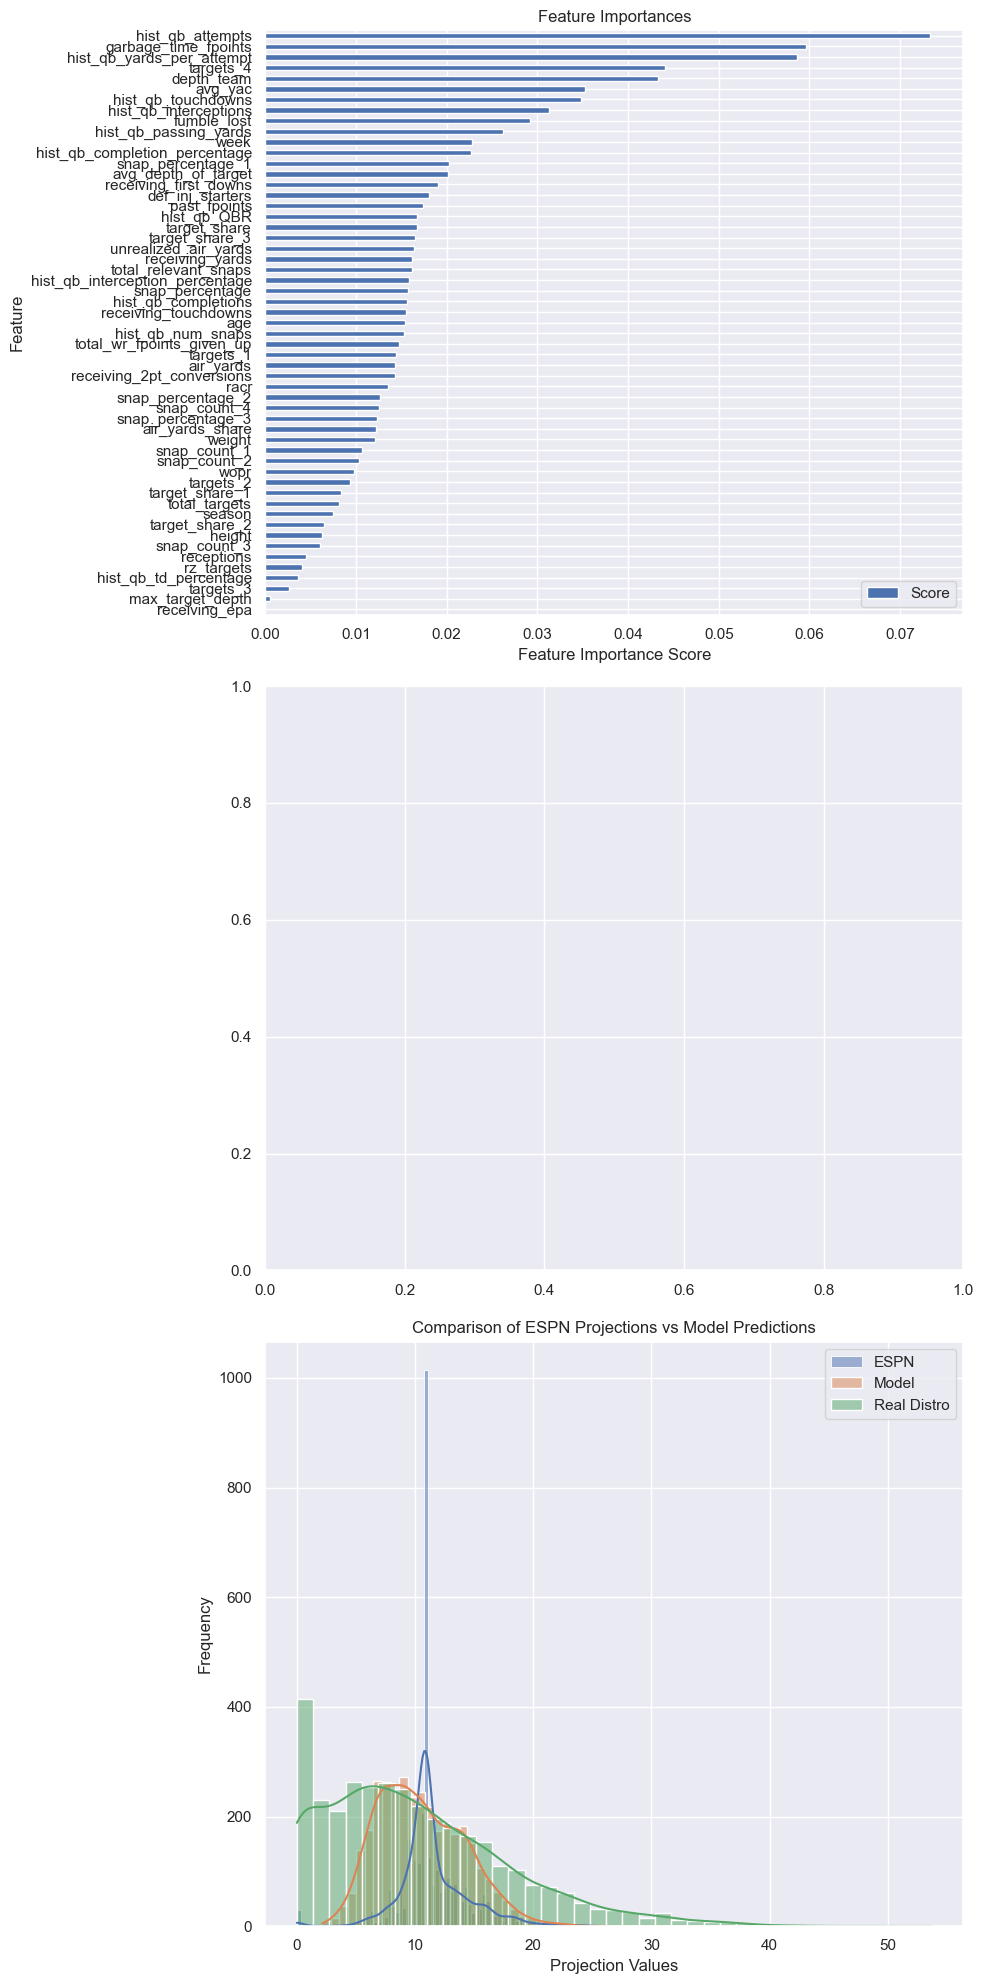

receiving_fpoints    yhat   player_id          game_id  \
1116                8.9  14.136  00-0033908   2020_15_NYJ_LA   
724                 0.0   5.558  00-0035703  2019_11_HOU_BAL   
2673                5.6   8.211  00-0032791  2017_17_BUF_MIA   
3357               10.4  22.120  00-0031235  2018_06_PHI_NYG   
380                 4.6   7.916  00-0029608  2021_11_IND_BUF   
439                22.7  13.573  00-0027874   2016_10_DEN_NO   
1093                6.5  11.687  00-0037487   2022_18_TB_ATL   
2234                3.5   5.384  00-0033009  2017_13_PIT_CIN   

           player_name  receiving_yards  receptions  receiving_touchdowns  \
1116       Cooper Kupp             39.0         5.0                   0.0   
724       Miles Boykin              0.0         0.0                   0.0   
2673      Jakeem Grant             26.0         3.0                   0.0   
3357     Odell Beckham             44.0         6.0                   0.0   
380        T.Y. Hilton             26.0         2.0                   0.0   
439   Demaryius Thomas             87.0         8.0                   1.0   
1093   Deven Thompkins             25.0         4.0                   0.0   
2234        Tyler Boyd             15.0         2.0                   0.0   

     week  fumble_lost  ESPN_projection     mae   espn_mae  
1116   15          0.0        14.276883   5.236   5.376882  
724    11          0.0        10.874442   5.558  10.874442  
2673   17          0.0        10.874442   2.611   5.274441  
3357    6          0.0        18.779497  11.720   8.379497  
380    11          0.0        11.132229   3.316   6.532229  
439    10          0.0        11.040477   9.127  11.659524  
1093   18          0.0        10.874442   5.187   4.374441  
2234   13          0.0        11.180626   1.884   7.680626

In [125]:
rf_opt, test_results = modelfit_general(
    RandomForestRegressor(**rf_search.best_params_), 
    data_pipeline = data_pipeline,
    scoring_function=mean_squared_error
)

test_results.sample(8)

In [128]:
# Tuning Bayesian Ridge
bayesian_ridge_bayes_grid = {
    'alpha_1': Real(1e-6, 1e-1, prior='log-uniform'),   # Shape parameter for the Gamma prior over alpha
    'alpha_2': Real(1e-6, 1e-1, prior='log-uniform'),   # Inverse scale parameter for the Gamma prior over alpha
    'lambda_1': Real(1e-6, 1e-1, prior='log-uniform'),  # Shape parameter for the Gamma prior over lambda
    'lambda_2': Real(1e-6, 1e-1, prior='log-uniform'),  # Inverse scale parameter for the Gamma prior over lambda
    'fit_intercept': Categorical([True, False])
}

cv_strategy = KFold(n_splits=3, shuffle=True, random_state=42)

br_search = BayesSearchCV(
    estimator = BayesianRidge(),
    search_spaces = bayesian_ridge_bayes_grid,
    scoring = 'neg_mean_squared_error',
    random_state = 42,
    n_jobs=-1,
    cv = cv_strategy,
)

_ = br_search.fit(data_pipeline.X_train_scaled, data_pipeline.y_train_final)

print(f"The best score achieved was: {-1*br_search.best_score_:.2f}")
br_search.best_params_

The best score achieved was: 54.49


OrderedDict([('alpha_1', 0.1),
             ('alpha_2', 1e-06),
             ('fit_intercept', False),
             ('lambda_1', 0.1),
             ('lambda_2', 0.1)])


Model Report
-------- TRAIN --------
MEAN_SQUARED_ERROR : 53.75
R2: 0.164480

Model Report
-------- TEST --------
MEAN_SQUARED_ERROR : 51.11
R2: 0.173045

Model Report
-------- ESPN --------
MEAN_SQUARED_ERROR : 61.01
R2: 0.056076


There are 3435 non-null ESPN entries in test
ESPN is better 1488 times. Or 43.32% of the time.
My model is better 1947 times. Or 56.68% of the time.
They are the same 0 times.


############ manual training plots ###########


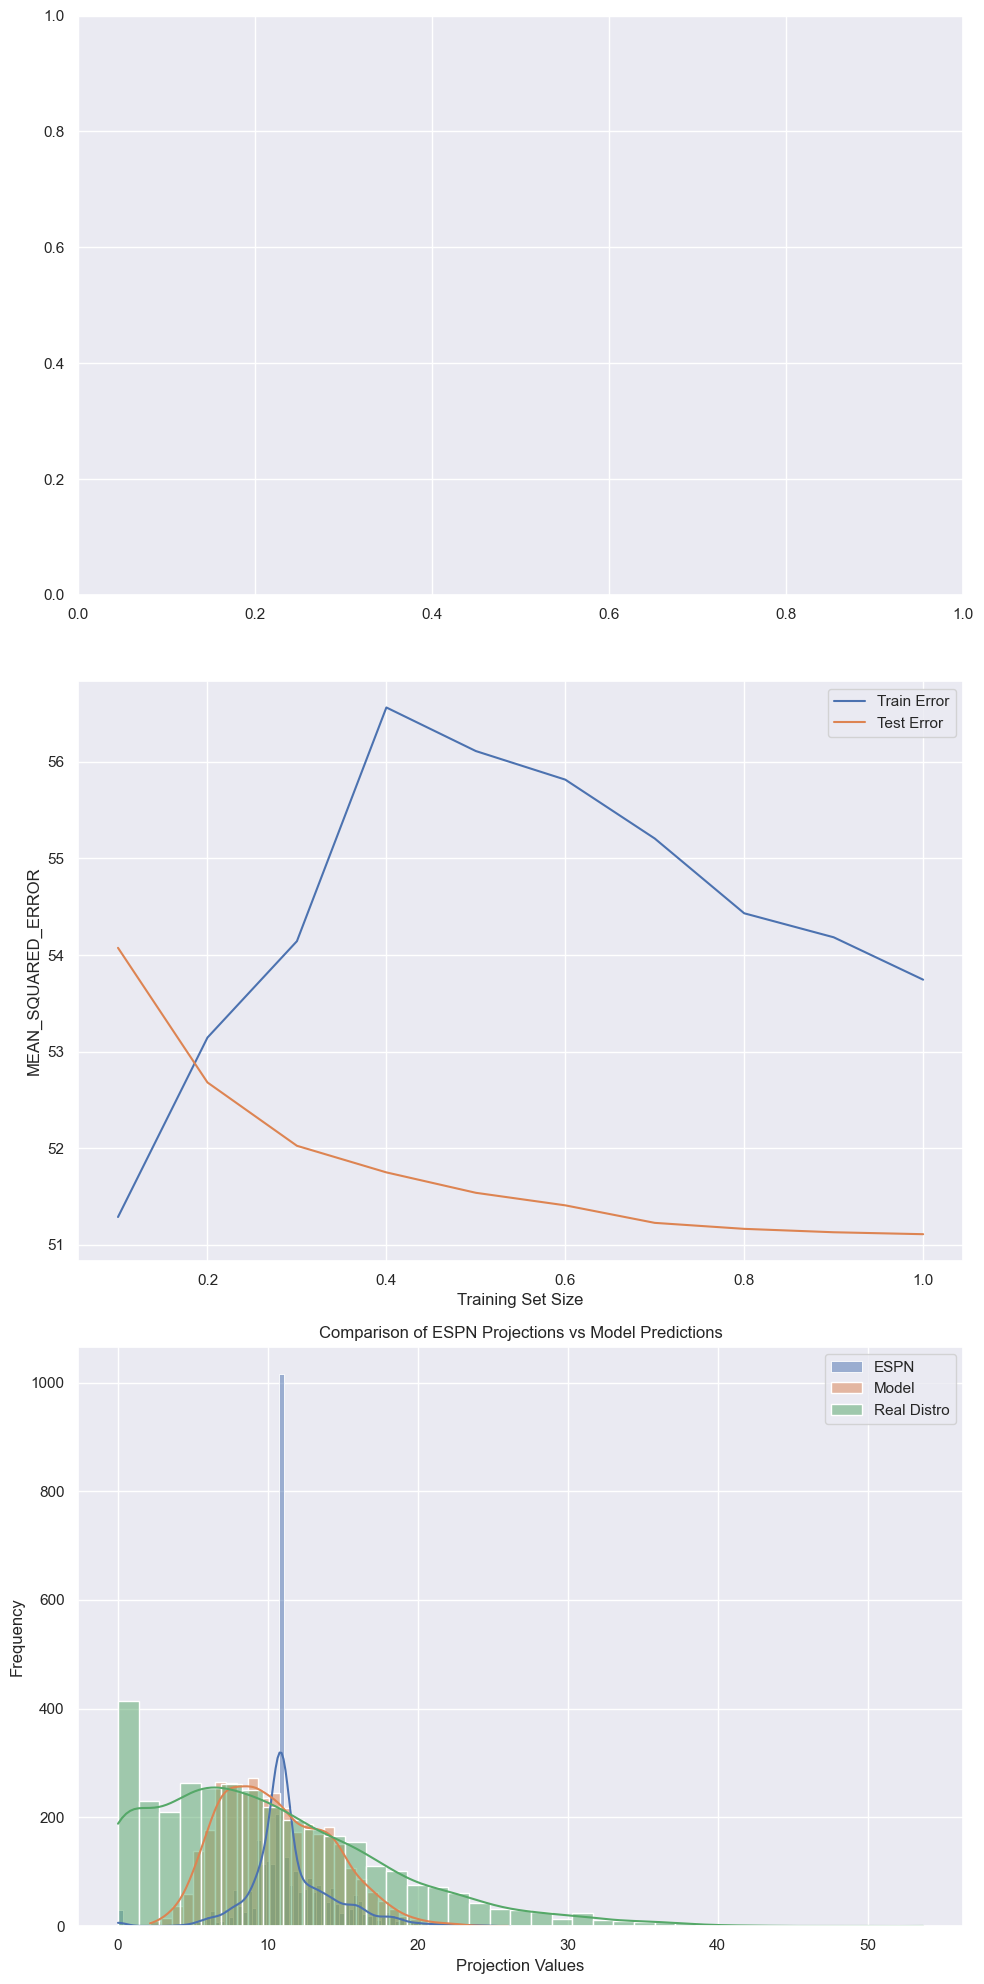

receiving_fpoints    yhat   player_id          game_id  \
1034           6.600000  10.317  00-0026035  2018_17_MIA_BUF   
2152          23.400000   8.436  00-0033127  2018_08_MIA_HOU   
3118          27.900000  17.300  00-0036900   2021_05_GB_CIN   
1713           9.200000  11.419  00-0027891   2015_10_DET_GB   
1839          28.300001  15.106  00-0033040  2023_06_CAR_MIA   
2260           7.300000  10.561  00-0034272   2018_17_DET_GB   
558           11.700000  16.597  00-0039067    2023_16_LV_KC   
1712           8.600000   6.678  00-0032355  2018_14_IND_HOU   

                   player_name  receiving_yards  receptions  \
1034            Danny Amendola             26.0         4.0   
2152               Will Fuller            124.0         5.0   
3118             Ja'Marr Chase            159.0         6.0   
1713               Golden Tate             52.0         4.0   
1839               Tyreek Hill            163.0         6.0   
2260  Marquez Valdes-Scantling             43.0         3.0   
558                Rashee Rice             57.0         6.0   
1712            Chester Rogers             36.0         5.0   

      receiving_touchdowns week  fumble_lost  ESPN_projection        mae  \
1034                   0.0   17          0.0        10.470589   3.717000   
2152                   1.0    8          0.0        13.159666  14.964000   
3118                   1.0    5          0.0        14.477254  10.600000   
1713                   0.0   10          0.0        10.958209   2.219000   
1839                   1.0    6          0.0        21.890546  13.194001   
2260                   0.0   17          0.0         9.272550   3.261000   
558                    0.0   16          0.0        17.107849   4.897000   
1712                   0.0   14          0.0        10.874442   1.922000   

       espn_mae  
1034   3.870589  
2152  10.240334  
3118  13.422746  
1713   1.758209  
1839   6.409455  
2260   1.972550  
558    5.407849  
1712   2.274442

In [129]:
br_opt, test_results = modelfit_general(
    BayesianRidge(**br_search.best_params_), 
    data_pipeline = data_pipeline,
    scoring_function=mean_squared_error
)

test_results.sample(8)

In [130]:
# Tuning Gradient Boosting 
gbr_bayes_grid = {
    'n_estimators': Integer(10, 1000),                 # Number of boosting stages
    'learning_rate': Real(0.001, 0.2, prior='log-uniform'),  # Shrinks contribution of each tree
    'max_depth': Integer(1, 30),                       # Maximum depth of the individual trees
    'min_samples_split': Integer(2, 20),               # Minimum number of samples required to split an internal node
    'min_samples_leaf': Integer(1, 20),                # Minimum number of samples required at a leaf node
    'subsample': Real(0.5, 1.0),                       # Fraction of samples used for fitting each base learner
    'max_features': Categorical(['sqrt', 'log2', None]),  # Number of features to consider when looking for the best split
    'loss': Categorical(['squared_error', 'huber', 'absolute_error', 'quantile'])  # Loss function to be optimized
}

cv_strategy = KFold(n_splits=3, shuffle=True, random_state=42)

gbr_search = BayesSearchCV(
    estimator = GradientBoostingRegressor(),
    search_spaces = gbr_bayes_grid,
    scoring = 'neg_mean_squared_error',
    random_state = 42,
    n_jobs=-1,
    cv = cv_strategy,
)

_ = gbr_search.fit(data_pipeline.X_train_scaled, data_pipeline.y_train_final)

print(f"The best score achieved was: {-1*gbr_search.best_score_:.2f}")
gbr_search.best_params_

The best score achieved was: 53.49


OrderedDict([('learning_rate', 0.015344020779478613),
             ('loss', 'squared_error'),
             ('max_depth', 4),
             ('max_features', 'log2'),
             ('min_samples_leaf', 5),
             ('min_samples_split', 8),
             ('n_estimators', 353),
             ('subsample', 0.9270597521696922)])


Model Report
-------- TRAIN --------
MEAN_SQUARED_ERROR : 46.49
R2: 0.277243

Model Report
-------- TEST --------
MEAN_SQUARED_ERROR : 49.44
R2: 0.200015

Model Report
-------- ESPN --------
MEAN_SQUARED_ERROR : 61.01
R2: 0.056076


There are 3435 non-null ESPN entries in test
ESPN is better 1488 times. Or 43.32% of the time.
My model is better 1947 times. Or 56.68% of the time.
They are the same 0 times.


############ manual training plots ###########


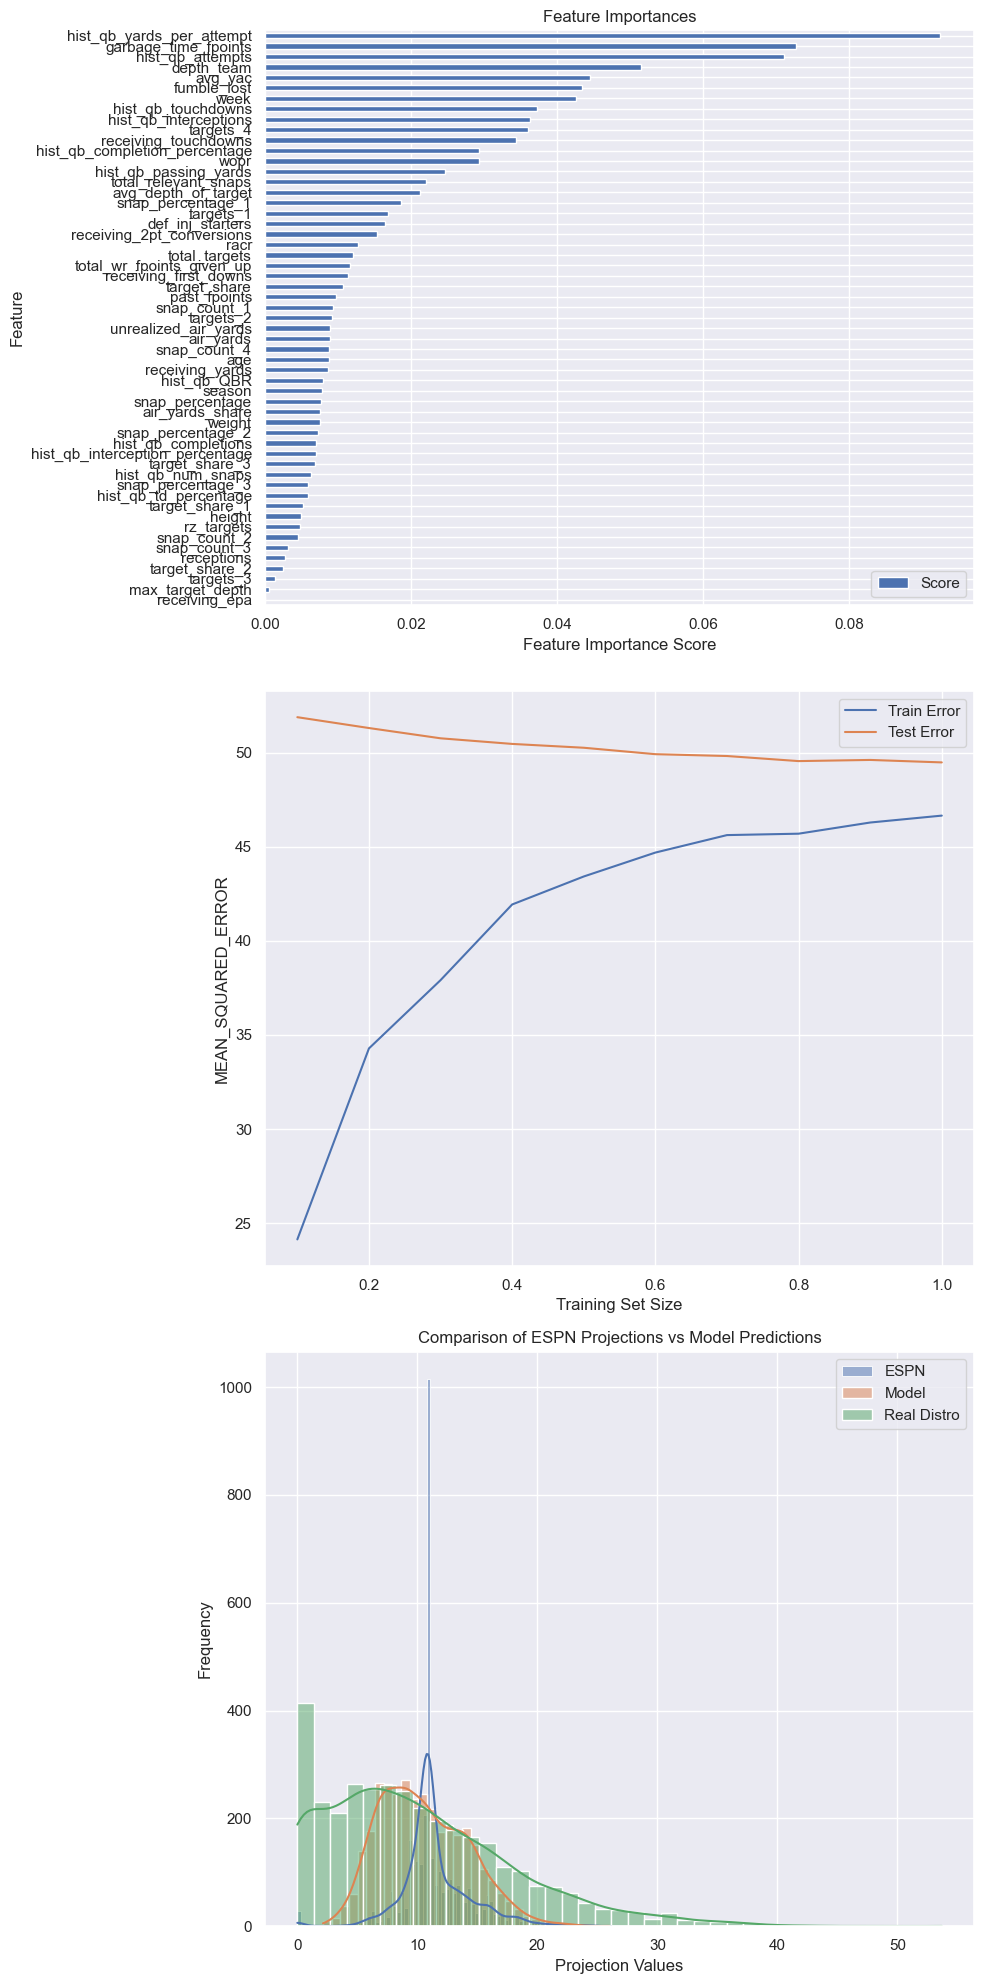

receiving_fpoints    yhat   player_id          game_id    player_name  \
979                 8.1   6.302  00-0031166  2018_05_OAK_LAC   Seth Roberts   
575                 9.6  11.366  00-0029000   2021_12_BUF_NO   Cole Beasley   
704                 9.4  10.589  00-0026182  2016_06_JAX_CHI    Eddie Royal   
2465                8.1   7.620  00-0036427    2021_15_NO_TB  Tyler Johnson   
842                 7.4  12.151  00-0027891  2015_17_DET_CHI    Golden Tate   
905                 4.9   7.198  00-0031189   2017_09_DET_GB     T.J. Jones   
301                26.8  13.523  00-0028497   2015_15_KC_BAL    Kamar Aiken   
1369               10.8  14.153  00-0034827  2021_15_CAR_BUF     D.J. Moore   

      receiving_yards  receptions  receiving_touchdowns week  fumble_lost  \
979              41.0         4.0                   0.0    5          0.0   
575              46.0         5.0                   0.0   12          0.0   
704              54.0         4.0                   0.0    6          0.0   
2465             41.0         4.0                   0.0   15          0.0   
842              34.0         4.0                   0.0   17          0.0   
905              29.0         2.0                   0.0    9          0.0   
301             128.0         8.0                   1.0   15          0.0   
1369             48.0         6.0                   0.0   15          0.0   

      ESPN_projection     mae   espn_mae  
979         10.874442   1.798   2.774442  
575         11.585188   1.766   1.985188  
704         10.874442   1.189   1.474441  
2465        10.874442   0.480   2.774441  
842         10.958209   4.751   3.558209  
905         10.874442   2.298   5.974441  
301         10.874442  13.277  15.925559  
1369        12.988720   3.353   2.188720

In [131]:
gbr_opt, test_results = modelfit_general(
    GradientBoostingRegressor(**gbr_search.best_params_), 
    data_pipeline = data_pipeline,
    scoring_function=mean_squared_error
)

test_results.sample(8)

In [132]:
# Lasso Regression 
# because I already did it
lasso_bayes_grid = {
    'alpha': Real(0.001, 100, prior="log-uniform"),  # Regularization strength, log-uniform for a wider exploration
    'fit_intercept': Categorical([True, False]),     # Whether to fit the intercept term
    'max_iter': Integer(1000, 10000),                # Maximum number of iterations
    'tol': Real(1e-4, 1e-2, prior="log-uniform"),    # Tolerance for optimization, log-uniform
    'selection': Categorical(['cyclic', 'random'])   # Selection algorithm for coordinate descent
}

cv_strategy = KFold(n_splits=3, shuffle=True, random_state=42)

lasso_search = BayesSearchCV(
    estimator = Lasso(),
    search_spaces = lasso_bayes_grid,
    scoring = 'neg_mean_squared_error',
    random_state = 42,
    n_jobs=-1,
    cv = cv_strategy,
)

_ = lasso_search.fit(data_pipeline.X_train_scaled, data_pipeline.y_train_final)

print(f"The best score achieved was: {-1*lasso_search.best_score_:.2f}")
lasso_search.best_params_

The best score achieved was: 54.47


OrderedDict([('alpha', 0.011974879218188773),
             ('fit_intercept', False),
             ('max_iter', 1000),
             ('selection', 'random'),
             ('tol', 0.01)])


Model Report
-------- TRAIN --------
MEAN_SQUARED_ERROR : 53.8
R2: 0.163580

Model Report
-------- TEST --------
MEAN_SQUARED_ERROR : 51.08
R2: 0.173480

Model Report
-------- ESPN --------
MEAN_SQUARED_ERROR : 61.01
R2: 0.056076


There are 3435 non-null ESPN entries in test
ESPN is better 1488 times. Or 43.32% of the time.
My model is better 1947 times. Or 56.68% of the time.
They are the same 0 times.


############ manual training plots ###########


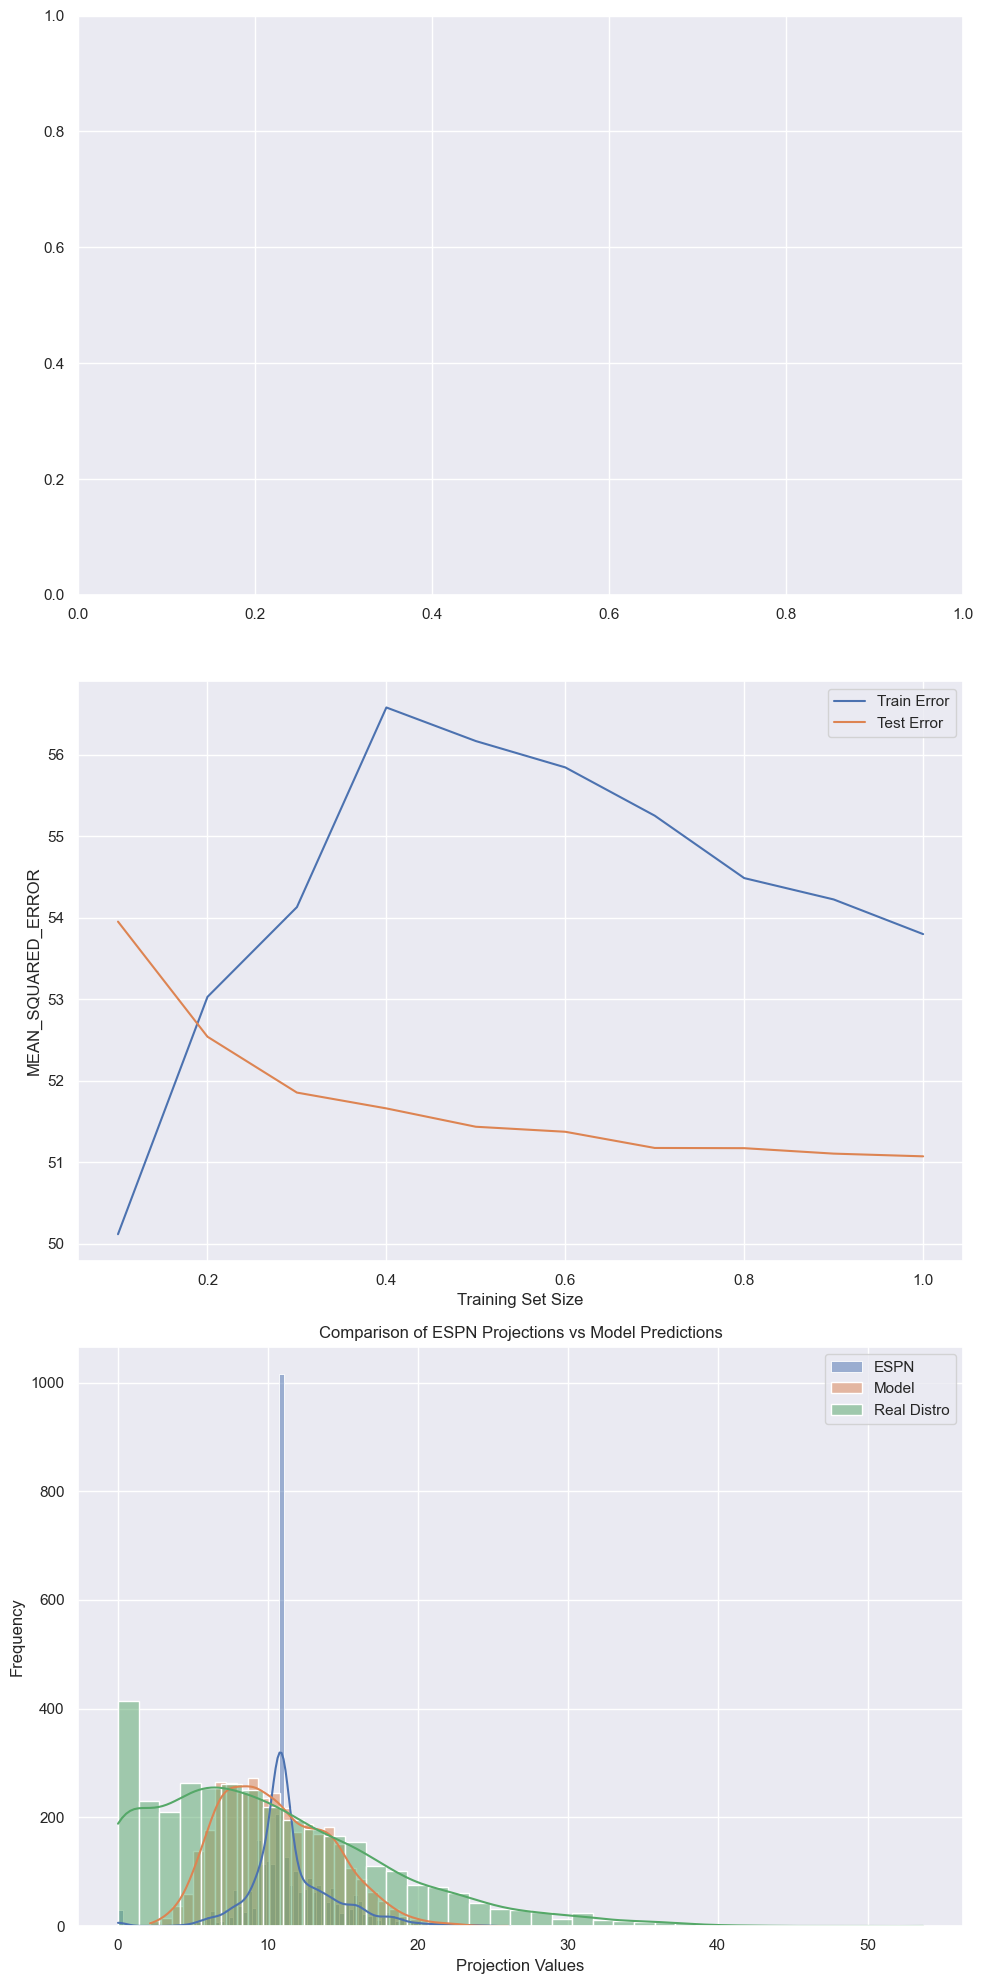

receiving_fpoints    yhat   player_id          game_id  \
1723                4.6   6.396  00-0032054  2018_13_CLE_HOU   
759                 5.1   7.360  00-0035535  2023_10_NYG_DAL   
2562                3.8  12.025  00-0035662  2023_10_ATL_ARI   
775                 0.0   9.843  00-0031359   2017_12_BUF_KC   
850                 0.0   8.685  00-0034860  2022_05_CHI_MIN   
1513               14.2  15.384  00-0030431   2018_05_LA_SEA   
1435                3.1   6.223  00-0032355  2016_14_HOU_IND   
3000                0.0   7.869  00-0026182   2015_12_CHI_GB   

           player_name  receiving_yards  receptions  receiving_touchdowns  \
1723  Breshad Perriman             26.0         2.0                   0.0   
759     Darius Slayton             21.0         3.0                   0.0   
2562    Marquise Brown             28.0         1.0                   0.0   
775    Kelvin Benjamin              0.0         0.0                   0.0   
850       Dante Pettis              0.0         0.0                   0.0   
1513      Robert Woods             92.0         5.0                   0.0   
1435    Chester Rogers             21.0         1.0                   0.0   
3000       Eddie Royal              0.0         0.0                   0.0   

     week  fumble_lost  ESPN_projection    mae   espn_mae  
1723   13          0.0        13.615061  1.796   9.015061  
759    10          0.0        10.531175  2.260   5.431175  
2562   10          0.0        13.639808  8.225   9.839808  
775    12          0.0        10.189445  9.843  10.189445  
850     5          0.0        10.163918  8.685  10.163918  
1513    5          0.0        15.137601  1.184   0.937600  
1435   14          0.0        10.874442  3.123   7.774441  
3000   12          0.0        10.874442  7.869  10.874442

In [133]:
lasso_opt, test_results = modelfit_general(
    Lasso(**lasso_search.best_params_), 
    data_pipeline = data_pipeline,
    scoring_function=mean_squared_error
)

test_results.sample(8)


Model Report
-------- TRAIN --------
MEAN_SQUARED_ERROR : 53.81
R2: 0.163456

Model Report
-------- TEST --------
MEAN_SQUARED_ERROR : 51.09
R2: 0.173426

Model Report
-------- ESPN --------
MEAN_SQUARED_ERROR : 61.01
R2: 0.056076


There are 3435 non-null ESPN entries in test
ESPN is better 1488 times. Or 43.32% of the time.
My model is better 1947 times. Or 56.68% of the time.
They are the same 0 times.


############ manual training plots ###########


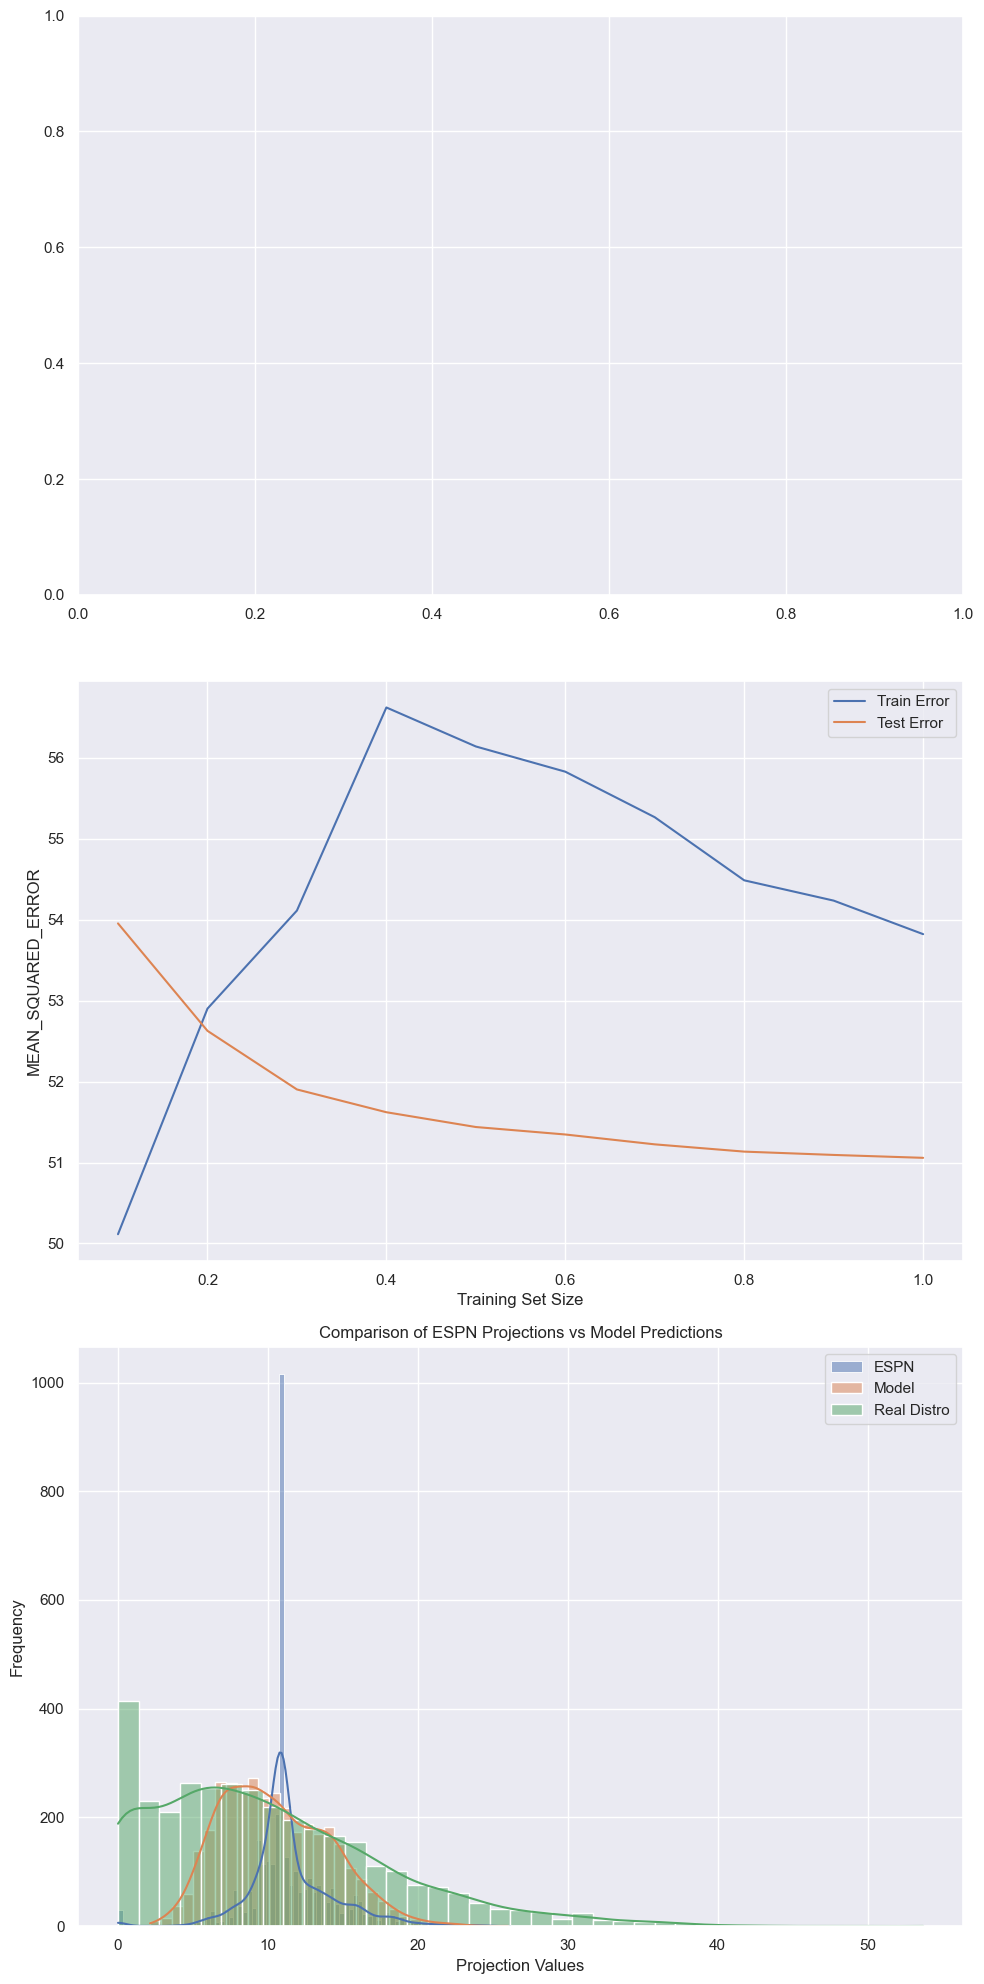

receiving_fpoints    yhat   player_id          game_id      player_name  \
2314               10.0  12.643  00-0033040   2021_17_KC_CIN      Tyreek Hill   
493                 3.8   7.588  00-0032778  2021_07_ATL_MIA     Tajae Sharpe   
1557               35.1   6.334  00-0030460  2015_12_PIT_SEA   Markus Wheaton   
1692                3.6  10.671  00-0033009  2022_12_CIN_TEN       Tyler Boyd   
2414                5.5  11.973  00-0030035   2023_13_CAR_TB     Adam Thielen   
2902                0.0   8.390  00-0031051  2016_11_ARI_MIN       John Brown   
944                20.1  12.706  00-0037247  2023_17_PIT_SEA   George Pickens   
289                 0.0   8.654  00-0032160  2018_12_ARI_LAC  Tyrell Williams   

      receiving_yards  receptions  receiving_touchdowns week  fumble_lost  \
2314             40.0         6.0                   0.0   17          0.0   
493              18.0         2.0                   0.0    7          0.0   
1557            201.0         9.0                   1.0   12          0.0   
1692             16.0         2.0                   0.0   12          0.0   
2414             25.0         3.0                   0.0   13          0.0   
2902              0.0         0.0                   0.0   11          0.0   
944             131.0         7.0                   0.0   17          0.0   
289               0.0         0.0                   0.0   12          0.0   

      ESPN_projection     mae   espn_mae  
2314        17.402797   2.643   7.402797  
493         10.874442   3.788   7.074442  
1557        10.874442  28.766  24.225559  
1692        12.387419   7.071   8.787419  
2414        14.521445   6.473   9.021445  
2902        10.854745   8.390  10.854745  
944         11.411901   7.394   8.688099  
289         11.203933   8.654  11.203933

In [134]:
# lasso isn't converging, let's increase the iterations
params = lasso_search.best_params_.copy()
params['max_iter'] = 10_000

lasso_opt, test_results = modelfit_general(
    Lasso(**params), 
    data_pipeline = data_pipeline,
    scoring_function=mean_squared_error
)

test_results.sample(8)

### PCA

In [135]:
# let's try PCA

pca = PCA(n_components = 8)
pca.fit(data_pipeline.X_train_scaled)
new_x = pca.transform(data_pipeline.X_train_scaled)
print(new_x.shape)

(6972, 8)


In [136]:
pca.explained_variance_ratio_

array([0.29214469, 0.11938777, 0.07862953, 0.0631472 , 0.04759619,
       0.04131772, 0.03352549, 0.02827703])

In [137]:
new_x_test = pca.transform(data_pipeline.X_test_scaled)

n_estimators: 52

Model Report
-------- TRAIN --------
MAE : 5.69
R2: 0.166923

Model Report
-------- TEST --------
MAE : 5.7
R2: 0.153043


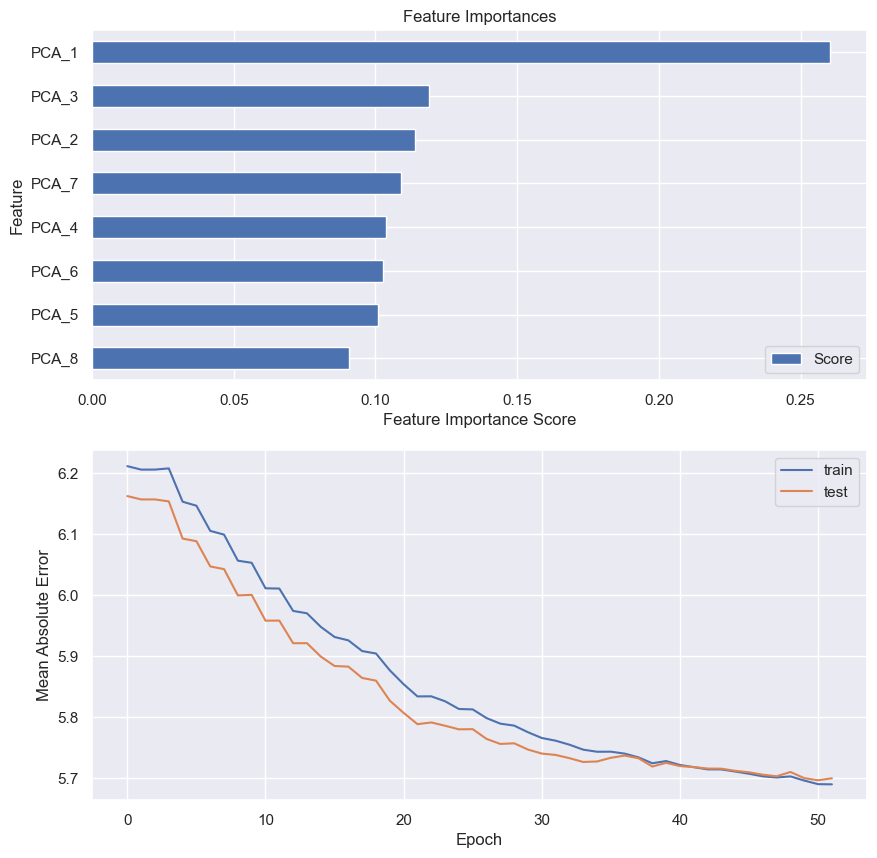

In [40]:
gbr_opt, test_results = modelfit_general(
    GradientBoostingRegressor(**gbr_search.best_params_), 
    data_pipeline = data_pipeline,
    scoring_function=mean_squared_error
)

test_results.sample(8)

Ok... now we are overfitting the model. Let's do a grid search right around this point to see if way can minimize the training loss and the overfitting gap.

### More Detailed Parameter Searching

In [98]:
if rf_search.best_params_['max_depth'] - 15 < 0:
    min_max_depth = 1
else:
    min_max_depth = rf_search.best_params_['max_depth'] - 15

max_max_depth = rf_search.best_params_['max_depth'] + 6

if rf_search.best_params_['min_samples_leaf'] - 15 < 0:
    min_min_samples_leaf = 1
else:
    min_min_samples_leaf = rf_search.best_params_['min_samples_leaf'] - 15

max_min_samples_leaf = rf_search.best_params_['min_samples_leaf'] + 6

if rf_search.best_params_['min_samples_split'] - 15 < 0:
    min_min_samples_split = 1
else:
    min_min_samples_split = rf_search.best_params_['min_samples_split'] - 15

max_min_samples_split = rf_search.best_params_['min_samples_split'] + 6

overfit_grid = {
    'max_depth':np.linspace(min_max_depth, max_max_depth, 5, dtype=int),
    'min_samples_leaf':np.linspace(min_min_samples_leaf, max_min_samples_leaf, 5, dtype=int),
    'min_samples_split': np.linspace(min_min_samples_split, max_min_samples_split, 5, dtype=int),
}

overfit_grid

{'max_depth': array([20, 25, 30, 35, 41]),
 'min_samples_leaf': array([ 1,  3,  6,  9, 12]),
 'min_samples_split': array([ 5, 10, 15, 20, 26])}

In [104]:

rf = RandomForestRegressor(bootstrap = rf_search.best_params_['bootstrap'], 
                           max_features = rf_search.best_params_['max_features'], 
                           n_estimators = rf_search.best_params_['n_estimators'])

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=overfit_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, return_train_score=True)

# Fit GridSearchCV
grid_search.fit(data_pipeline.X_train_scaled, data_pipeline.y_train_final)

# Best model from grid search
best_rf = grid_search.best_estimator_

# Predict on the test set
predictions = best_rf.predict(data_pipeline.X_test_scaled)

# Evaluate the model
mse = mean_squared_error(data_pipeline.y_test_final, predictions)

print("Best Hyperparameters:", grid_search.best_params_)
print("Mean Squared Error on Test Set:", mse)

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 6, 'min_samples_split': 20}
Mean Squared Error on Test Set: 49.79545210124804


In [105]:
pd.DataFrame(grid_search.cv_results_).sort_values(by = 'rank_test_score').head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
13       20.206515      0.304513         0.233165        0.005770   
68       19.453551      0.181397         0.231168        0.007373   
114      20.941278      2.390957         0.281103        0.048599   
87       23.540123      1.945239         0.289768        0.026494   
14       18.375682      0.992557         0.222302        0.013889   

     param_max_depth  param_min_samples_leaf  param_min_samples_split  \
13                20                       6                       20   
68                30                       9                       20   
114               41                       6                       26   
87                35                       6                       15   
14                20                       6                       26   

                                                params  split0_test_score  \
13   {'max_depth': 20, 'min_samples_leaf': 6, 'min_...         -54.275686   
68   {'max_depth': 30, 'min_samples_leaf': 9, 'min_...         -54.179921   
114  {'max_depth': 41, 'min_samples_leaf': 6, 'min_...         -54.345866   
87   {'max_depth': 35, 'min_samples_leaf': 6, 'min_...         -54.399905   
14   {'max_depth': 20, 'min_samples_leaf': 6, 'min_...         -54.359104   

     split1_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
13          -58.430302  ...       -53.333798        3.012854                1   
68          -58.413357  ...       -53.335283        2.976500                2   
114         -58.563578  ...       -53.336913        3.071228                3   
87          -58.423686  ...       -53.343196        3.022662                4   
14          -58.524191  ...       -53.346513        3.065218                5   

     split0_train_score  split1_train_score  split2_train_score  \
13           -32.156404          -31.559673          -32.334264   
68           -34.487054          -33.848411          -34.677193   
114          -34.462428          -33.953555          -34.674425   
87           -29.550474          -29.066069          -29.642939   
14           -34.551567          -33.937588          -34.694807   

     split3_train_score  split4_train_score  mean_train_score  std_train_score  
13           -33.051063          -32.750947        -32.370470         0.512347  
68           -35.384872          -35.111619        -34.701830         0.530949  
114          -35.410809          -35.156944        -34.731632         0.514455  
87           -30.382463          -30.117122        -29.751813         0.459087  
14           -35.514646          -35.174205        -34.774563         0.541120  

[5 rows x 23 columns]


Model Report
-------- TRAIN --------
MEAN_SQUARED_ERROR : 44.15
R2: 0.313701

Model Report
-------- TEST --------
MEAN_SQUARED_ERROR : 49.8
R2: 0.194203

Model Report
-------- ESPN --------
MEAN_SQUARED_ERROR : 61.01
R2: 0.056076


There are 3435 non-null ESPN entries in test
ESPN is better 1488 times. Or 43.32% of the time.
My model is better 1947 times. Or 56.68% of the time.
They are the same 0 times.


############ manual training plots ###########


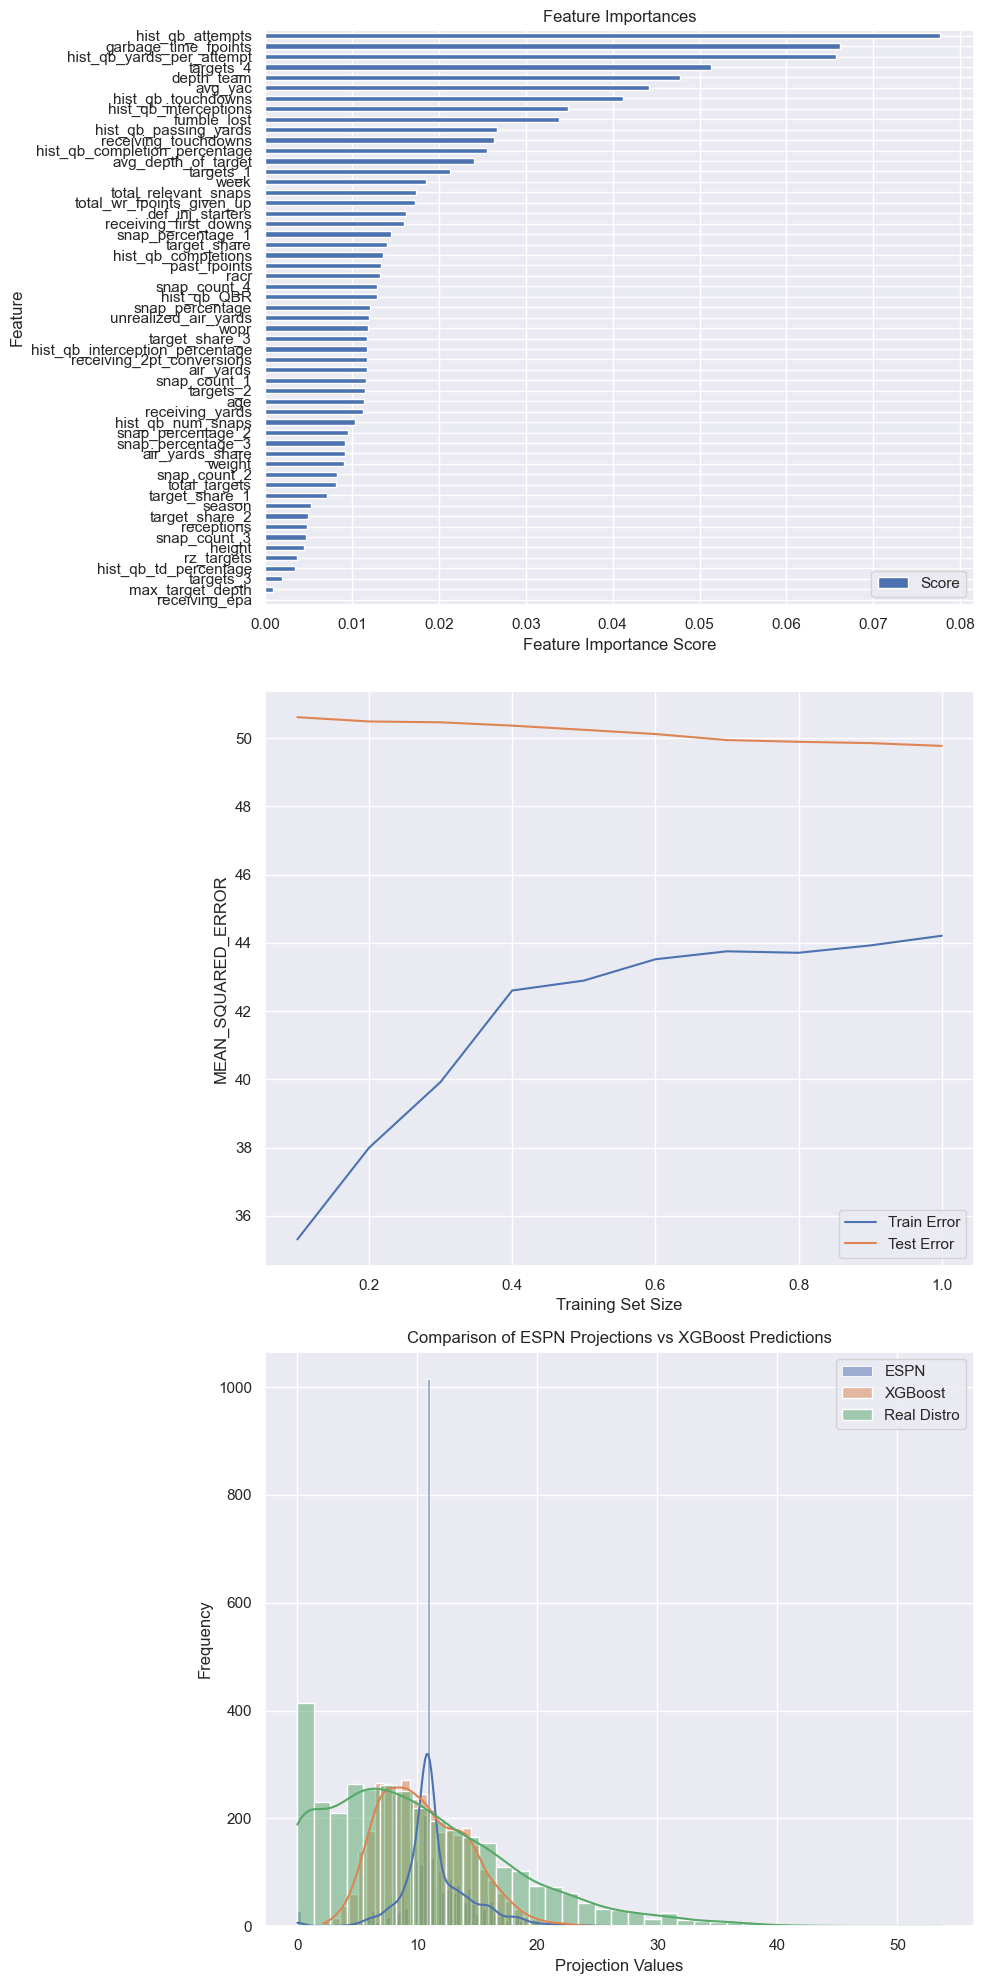

In [112]:
params = rf_search.best_params_.copy()
params['max_depth'] = 8
params['min_samples_leaf'] = 6
params['min_samples_split'] = 20
rf_opt, test_results = modelfit_general(
    RandomForestRegressor(**params), 
    data_pipeline = data_pipeline,
    scoring_function=mean_squared_error,
    retrain_for_plots = True
)